# Processing Data, Gaining Some Insights and Preparing Tokenizations

## Table Of Contents (ToC) - to do later


1. [Utility Functions](#99-utility-functions)
   - 1) read_parquet_in_batches - function
   - 2) save_batches_to_parquet - function

2. [Early Processing](#early-processing)
   - Step 0: Setup
   - Step 1: Filtering rows + removal of missing records (missing abstracts are, after checking manually)

3. [Further Processing](#further-processing)
   - [Variable: `uid + parsed_date`](variable+)
   - [Title + Abstract](#title-+-abstract)
      - [0) Insight into simple and Hugging Face tokenization](#insight-into-simple-and-hugging-face-tokenization)
            - Conclusions from 0)

4. [Variables](#variables)

     
     - [1) Dictionary-Based Disease Detection](#1-dictionary-based-disease-detection)
     - [2) SciSpacy (or spaCy) Biomedical NER Approach](#scispacy-or-spacy-biomedical-ner-approach)
     - [WHAT'S NEXT?](#whats-next)
     - [Further Analysis Of Abstract And Title](#further-analysis-of-abstract-and-title)
     - [3) EMBEDDINGS - maybe to get into later, very heavy for computer](#embeddings)

5. [Additional Variables](#additional-variables)
   - `mesh_terms`
   - `journal`
   - `abstract`
   - `authors`
   - `affiliations`
   - `mesh_terms`
   - `keywords`
   - `coi_statement`


## `99)` Utility Functions

### 1) read_parquet_in_batches - function

In [5]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add custom logic here if necessary)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

````
# EXAMPLE USAGE
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P1_all.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")
    df.head()
    ````


### 2) save_batches_to_parquet - function

In [6]:
import os
import pandas as pd
from tqdm import tqdm

def save_and_merge_in_batches(
    df: pd.DataFrame,
    batch_size: int,
    output_folder: str,
    final_filename: str = "final_merged.parquet",
    temp_batch_prefix: str = "temp_batch_"
):
    """
    Splits 'df' into multiple batches (size = batch_size), writes each batch to a Parquet file,
    then merges them into one final Parquet, with a progress bar showing how many batches are done.

    Steps:
    ------
    1) Creates subfolder 'temp_batches' in output_folder for batch files.
    2) For each chunk of rows:
       - Writes it to 'temp_batch_X.parquet'
       - Increments a progress bar
    3) Reads & merges all batch files into 'final_filename', then removes them.

    Returns:
    --------
    str -> path to the final merged Parquet file.
    """

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Subfolder for temporary batch files
    temp_folder = os.path.join(output_folder, "temp_batches")
    os.makedirs(temp_folder, exist_ok=True)

    total_rows = len(df)
    batch_count = (total_rows + batch_size - 1) // batch_size
    print(f"Splitting DataFrame of {total_rows} rows into {batch_count} batches (size={batch_size}).")

    temp_files = []
    current_row = 0
    batch_index = 1

    # -- 1) SAVE IN MULTIPLE BATCHES WITH A PROGRESS BAR FOR THE BATCHES --
    with tqdm(total=batch_count, desc="Saving Batches", unit="batch") as pbar:
        while current_row < total_rows:
            end_row = min(current_row + batch_size, total_rows)
            df_batch = df.iloc[current_row:end_row]

            temp_file_name = f"{temp_batch_prefix}{batch_index}.parquet"
            temp_file_path = os.path.join(temp_folder, temp_file_name)

            # Write the chunk (one shot for each batch)
            df_batch.to_parquet(temp_file_path, index=False, compression="snappy")

            temp_files.append(temp_file_path)

            # Update progress bar
            pbar.update(1)

            # Optional: Print log
            print(f"  -> Batch {batch_index} rows [{current_row}:{end_row}] saved to {temp_file_path}")

            current_row = end_row
            batch_index += 1

    # -- 2) MERGE ALL BATCH FILES INTO A SINGLE PARQUET --
    final_file_path = os.path.join(output_folder, final_filename)
    print(f"\nMerging {len(temp_files)} batch files into {final_file_path}...")

    merged_parts = []
    # Another progress bar for reading merges (optional)
    with tqdm(total=len(temp_files), desc="Merging Batches", unit="file") as pbar_merge:
        for file_path in temp_files:
            merged_parts.append(pd.read_parquet(file_path))
            pbar_merge.update(1)

    df_merged = pd.concat(merged_parts, ignore_index=True)
    df_merged.to_parquet(final_file_path, index=False, compression="snappy")
    print(f"Final merged DataFrame saved as: {final_file_path}\n")

    # -- 3) CLEAN UP TEMPORARY FILES --
    for path in temp_files:
        os.remove(path)
    os.rmdir(temp_folder)

    print("Temporary batch files removed. All done!")
    return final_file_path

````
# ---------------------------
# EXAMPLE USAGE
# ---------------------------
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P4_final_merged.parquet"
    batch_size = 100_000  # e.g. if you want ~10 batches

    result_path = save_and_merge_in_batches(
        df=df_final,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")
````

## Early Processing 

*removing NA + filtering rows with wrong dates* (after 2024 and before 1995 articles will be excluded, as currently its 2024, and 1994 had low amount of articles)

### Step 0: Setup

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_parquet("Data/1.EarlyCleaned/cleaned_parquet/final/PubMedAbstracts_final.parquet")
df.head()

,uid,title,journal,pubdate,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,date,parsed_date
0,10150804,Evaluation of survival in medically treated pa...,"Journal of insurance medicine (New York, N.Y.)",None-01-01,General: Articles published in medical journal...,Iacovino J R,"New York Life Insurance Company, New York, USA.",Adolescent; Adult; Age Distribution; Chelation...,,N/A,1994-01-01,1994-01-01
1,9061841,Cohort versus cross-sectional design in large ...,Statistics in medicine,1994-Jan-15,General: In planning large longitudinal field ...,Feldman H A; McKinlay S M,"New England Research Institute, Inc., Watertow...",Analysis of Variance; Cluster Analysis; Cohort...,,N/A,1994-01-01,1994-01-15
2,9061840,Network analytic methods for epidemiological r...,Statistics in medicine,1994-Jan-15,General: The authors measure the efficacy of t...,Altmann M; Wee B C; Willard K; Peterson D; Gat...,"Division of Health Computer Sciences, Universi...",Analysis of Variance; Communicable Disease Con...,,N/A,1994-01-01,1994-01-15
3,9061838,"Estimating age, period and cohort effects usin...",Statistics in medicine,1994-Jan-15,General: To understand cancer aetiology better...,Holford T R; Zhang Z; McKay L A,"Department of Epidemiology and Public Health, ...","Age Factors; Cell Transformation, Neoplastic; ...",,N/A,1994-01-01,1994-01-15
4,16353609,A perspective on the hormonal abnormalities of...,Obesity research,1994-Jan-01,General: Studies in our laboratory and elsewhe...,Zumoff B; Strain G W,"Division of Endocrinology and Metabolism, Depa...",Adolescent; Adult; Estradiol; Estrone; Female;...,,N/A,1994-01-01,1994-01-01


In [7]:
# na per column 
df.isna().sum()

uid               0
title             0
journal           0
pubdate           0
abstract         14
authors           0
affiliations      0
mesh_terms        0
keywords          0
coi_statement     0
date              0
parsed_date       0
dtype: int64

### **Step 1**: Filtering rows + removal of missing records 

(missing abstracts are, after checking manually, missing from articles itself, they are **NOT** due to mistakes in the processing or during phase of data gathering)

In [8]:
missing_abstracts = df[df["abstract"].isna()]
print("Rows where 'abstract' is missing:")
missing_abstracts

Rows where 'abstract' is missing:


,uid,title,journal,pubdate,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,date,parsed_date
13973,7479089,Transverse temperature-gradient single-strand ...,Nucleic acids research,1995-Oct-25,None,Grace M B; Bambeck G S; Buzard G S; Weintraub B D,"Diabetes and Digestive and Kidney Diseases, Na...","Electrophoresis, Polyacrylamide Gel; Exons; Hu...",,N/A,1995-10-01,1995-10-25
396952,19951381,Probing the limits of regional tissue oxygenat...,"Critical care (London, England)",2009-01-01,None,Pinsky Michael R; Payen Didier,"Critical Care Medicine, Bioengineering, Cardio...",Hemoglobins; Humans; Microcirculation; Oxygen ...,,N/A,2009-01-01,2009-01-01
714156,28549132,Selective impairment of goal-directed decision...,Brain : a journal of neurology,2017-Jun-01,None,Reber Justin; Feinstein Justin S; O'Doherty Jo...,Department of Psychological and Brain Sciences...,Aged; Brain Diseases; Choice Behavior; Cogniti...,decision-making; devaluation; instrumental; re...,N/A,2017-06-01,2017-06-01
748429,29240851,Off Target But Hitting the Mark.,Journal of hospital medicine,2018-Apr-01,None,Kara Areeba; Mookherjee Somnath; Gavin Warren;...,"Inpatient Medicine, Indiana University Health ...",Abdominal Pain; Adult; Cholecystectomy; Doxycy...,,N/A,2018-04-01,2018-04-01
771404,30496332,Towards Scalable Hospital-Based Palliative Car...,Journal of hospital medicine,2018-Dec-01,None,Courtright Katherine R; O'Connor Nina R,"Division of Pulmonary, Allergy, and Critical C...",Hospitalists; Hospitals; Humans; Palliative Care,,N/A,2018-12-01,2018-12-01
771443,30475933,The vaginal wellness consultation for treatmen...,Seminars in cutaneous medicine and surgery,2018-Dec-01,None,Miller Misha D,Mohs Micrographic Surgery and Cutaneous Oncolo...,Atrophy; Catheter Ablation; Female; Humans; La...,,N/A,2018-12-01,2018-12-01
775681,30667412,Nudging Providers to Improve Sleep for Hospita...,Journal of hospital medicine,2019-Jan-01,None,Auriemma Catherine L; Greysen S Ryan,Division of Pulmonary and Critical Care Medici...,Choice Behavior; Decision Making; Goals; Human...,,N/A,2019-01-01,2019-01-01
775682,30667405,The Journal of Hospital Medicine in 2019 and B...,Journal of hospital medicine,2019-Jan-01,None,Shah Samir S,Divisions of Hospital Medicine and Infectious ...,Biomedical Research; Hospital Medicine; Humans...,,N/A,2019-01-01,2019-01-01
776638,30534643,Clinical Operations Research: A New Frontier f...,Journal of hospital medicine,2019-Jan-08,None,Kohn Rachel; Greysen S Ryan,"Department of Medicine, Perelman School of Med...",General Practice; Humans,,N/A,2019-01-01,2019-01-08
792798,31010740,RETRACTED: Comprehensive Analysis of the Expre...,Molecular therapy : the journal of the America...,2019-Jun-05,None,Sun Cheng-Cao; Li Shu-Jun; Hu Wei; Zhang Jian;...,Department of Occupational and Environmental H...,"Biomarkers, Tumor; Breast Neoplasms; Computati...",E2Fs; Kaplan-Meier Plotter; biomarkers; breast...,N/A,2019-06-01,2019-06-05


In [9]:
x = (df.shape)

# 1) Drop rows with missing abstract (14) -> We have looked into them and it's really like they are missing abstract not due to fault that comes from coding but they are just empty on website. they contribute to ~ 1% of dataset so it is not much of an issue
df = df.dropna(subset=["abstract"])

print("Removed missing abstract rows:")
print(x[0]-df.shape[0])

# 2) Drop rows with year == 2025
# first ensure parsed_date is datetime
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

#df = df[df["parsed_date"].dt.year != 2025]
# Exclude years 1994 and 2025 ; 1994 has low amount of articles
df = df[(df["parsed_date"].dt.year != 1994) & (df["parsed_date"].dt.year != 2025)]

print("Removed total rows:")
print(x[0] - df.shape[0])

Removed missing abstract rows:
14
Removed total rows:
1890


In [10]:
# Selecting only columns that we will be working with
df = df[["uid", "title", "journal", "abstract", "authors", "affiliations", "mesh_terms", "keywords", "coi_statement", "parsed_date"]].copy()

## Further Processing

In [11]:
df.columns

Index(['uid', 'title', 'journal', 'abstract', 'authors', 'affiliations',
       'mesh_terms', 'keywords', 'coi_statement', 'parsed_date'],
      dtype='object')

### Variable: `uid` + `parsed_date`

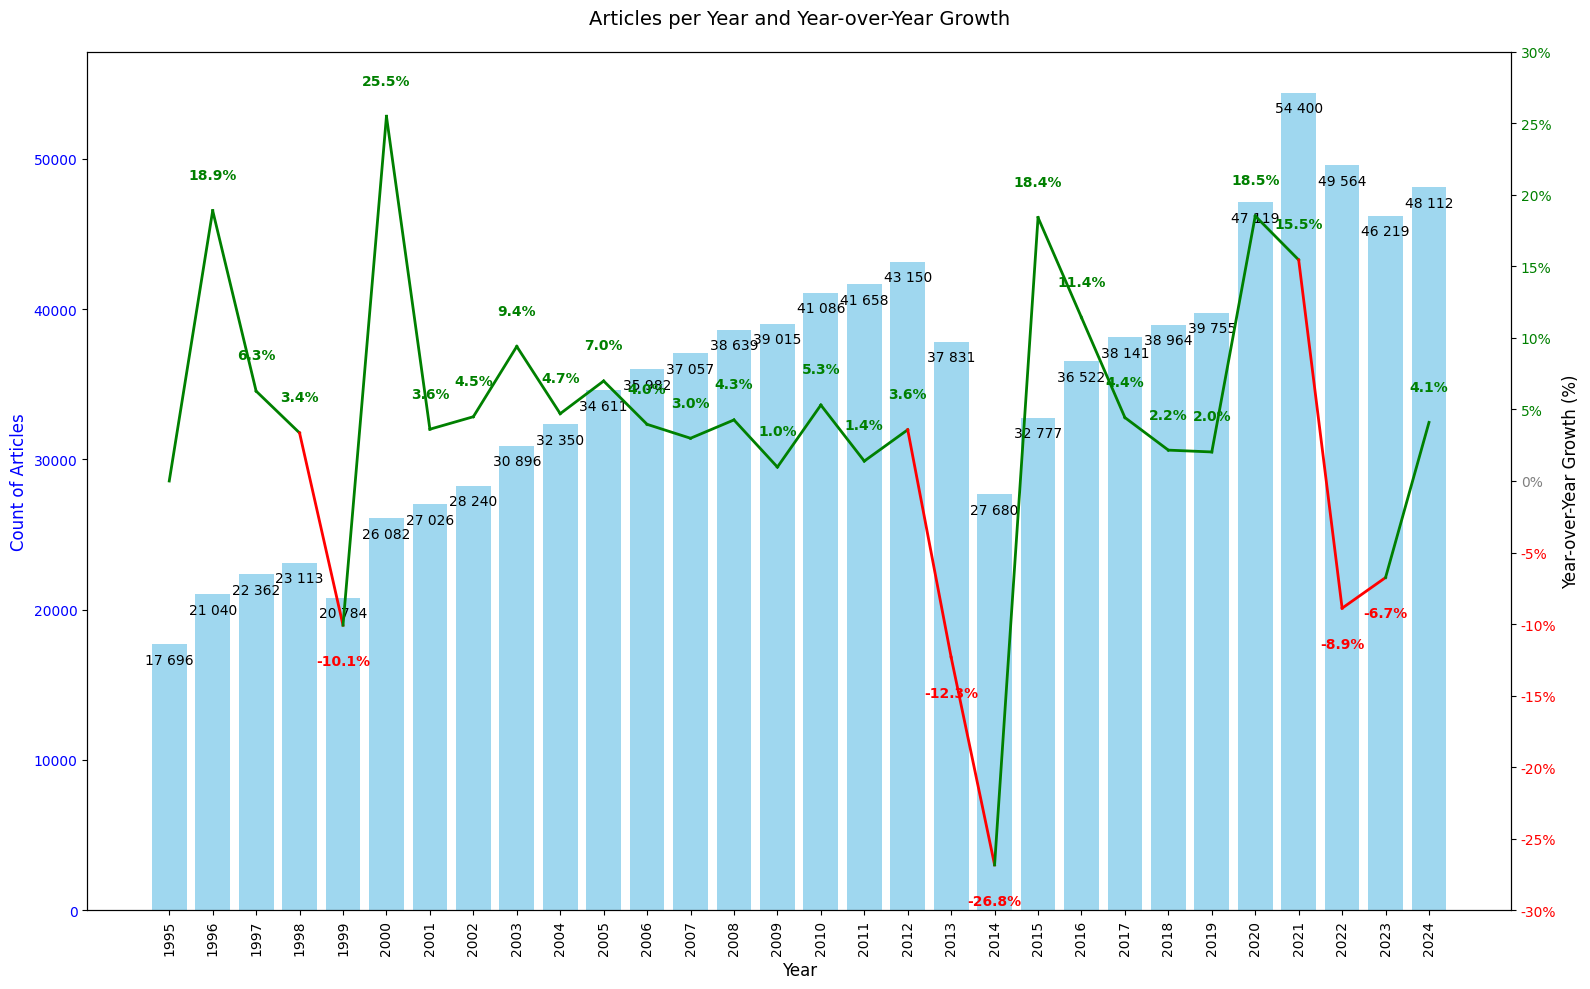

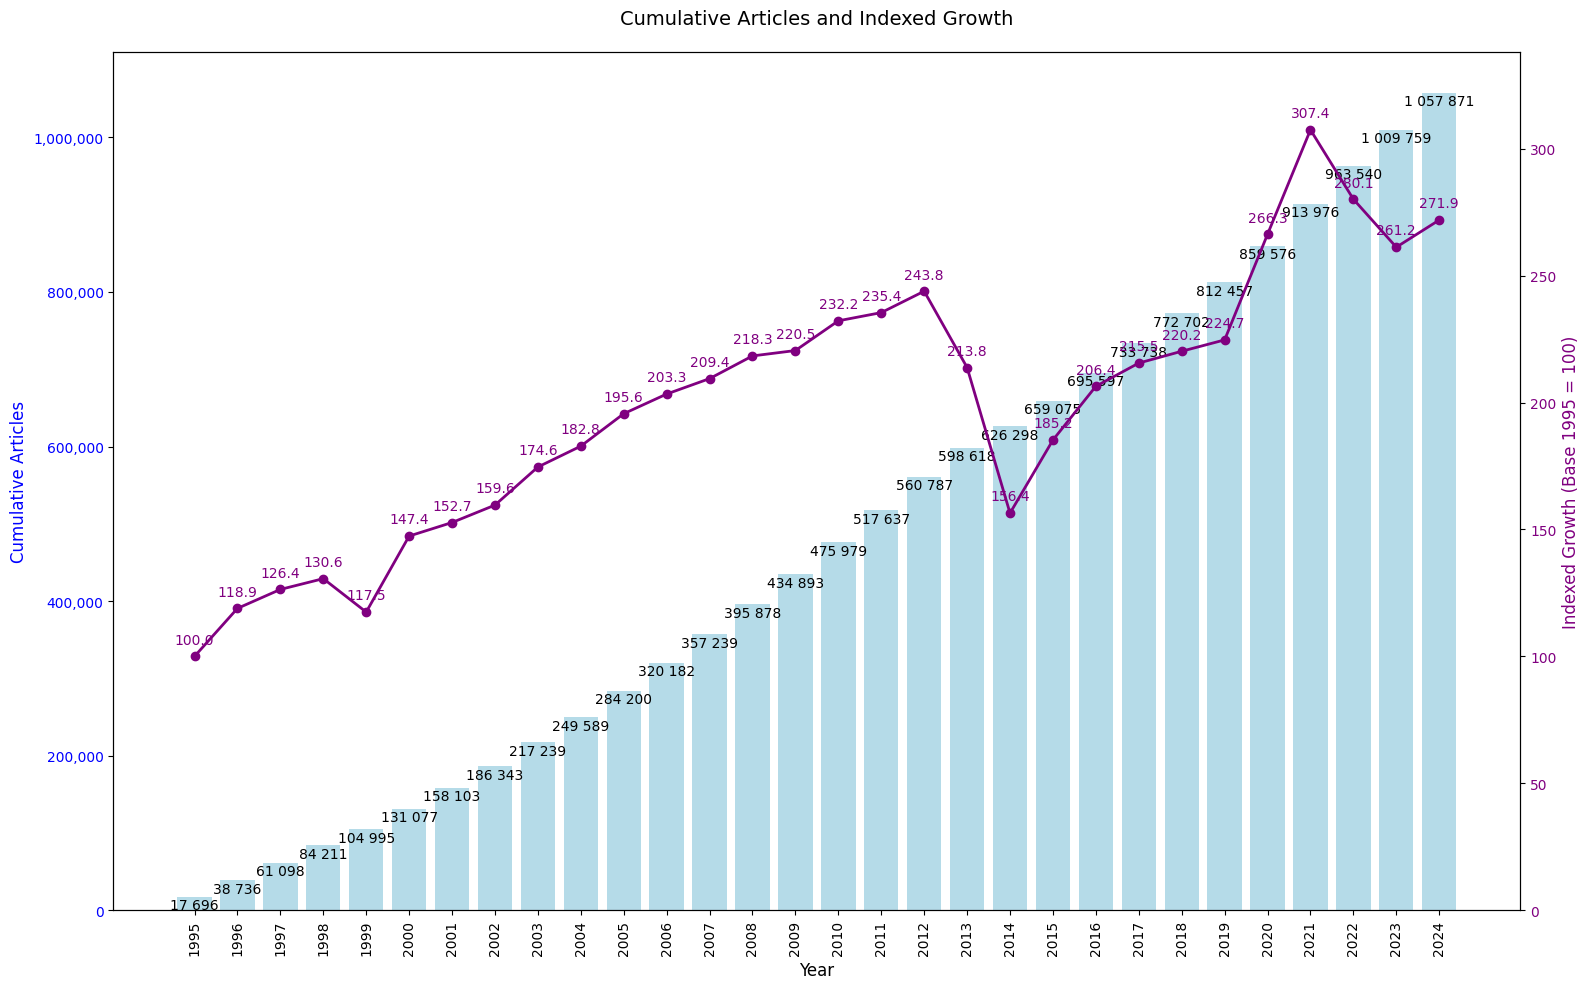

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# parsed date into datetime format
df["parsed_date"] = pd.to_datetime(df["parsed_date"], errors="coerce")

# Compute articles per year
articles_per_year = df.groupby(df["parsed_date"].dt.year)["uid"].count().sort_index()

# Compute Year-over-Year % change
growth_pct = articles_per_year.pct_change().fillna(0) * 100
growth_pct.iloc[0] = 0  # Set the first year's growth to 0 to avoid outliers

# Ensure all years from 1995 to 2024 are represented (even if no data for some years)
all_years = pd.Series(range(1995, 2025), name="Year")
articles_per_year = articles_per_year.reindex(all_years, fill_value=0)
growth_pct = growth_pct.reindex(all_years, fill_value=0)

# Compute cumulative number of articles
cumulative_articles = articles_per_year.cumsum()

# Compute Indexed Growth (base 1995 = 100)
indexed_growth = (articles_per_year / articles_per_year.iloc[0]) * 100

# --- Visualization 1: Articles per Year + YoY Growth ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Adjust the bar width and opacity
bar_width = 0.8
bars = ax1.bar(articles_per_year.index, articles_per_year.values, color="skyblue", alpha=0.8, width=bar_width, label="Article Count")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Count of Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(articles_per_year.index)
ax1.set_xticklabels(articles_per_year.index, rotation=90, fontsize=10)

# Annotate each bar with its count (formatted with commas or spaces), slightly raised
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 1500,  # Slightly raised above bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for growth percentage
ax2 = ax1.twinx()
ax2.set_ylabel("Year-over-Year Growth (%)", fontsize=12)
ax2.tick_params(axis='y')

# Custom Y-axis ticks with range -30 to 30
ax2.set_ylim(-30, 30)
ax2.set_yticks(range(-30, 35, 5))
ax2.set_yticklabels(
    [f"{abs(t)}%" if t == 0 else f"{t}%" for t in range(-30, 35, 5)],
    color="gray",
    fontsize=10,
)

# Change color of Y-axis labels dynamically
for label in ax2.get_yticklabels():
    value = int(label.get_text().replace("%", ""))
    if value > 0:
        label.set_color("green")
    elif value < 0:
        label.set_color("red")
    else:
        label.set_color("gray")

# Align the line chart with the center of bars
line_x = articles_per_year.index + (bar_width / 2 - 0.4)
colors = ["green" if y > 0 else "red" for y in growth_pct.values]

# Plot colored growth lines based on percentage
for i in range(1, len(articles_per_year)):
    ax2.plot(
        [line_x[i - 1], line_x[i]],
        [growth_pct.values[i - 1], growth_pct.values[i]],
        color=colors[i],
        linewidth=2
    )

# Annotate growth percentage below/above dots in bold
for x, y in zip(line_x, growth_pct.values):
    if abs(y) > 0.5:  # Annotate only significant changes
        offset = -2 if y < 0 else 2
        ax2.text(
            x, y + offset,
            f"{y:.1f}%", color="green" if y > 0 else "red",
            ha="center", va="bottom" if y > 0 else "top", fontsize=10, fontweight="bold"
        )

# Add a title and adjust layout
ax1.set_title("Articles per Year and Year-over-Year Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()

# --- Visualization 2: Indexed Growth + Cumulative Articles ---
fig, ax1 = plt.subplots(figsize=(16, 10))

# Plot cumulative number of articles as bars
bars = ax1.bar(cumulative_articles.index, cumulative_articles.values, color="lightblue", alpha=0.9, width=bar_width, label="Cumulative Articles")
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Cumulative Articles", color="blue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_xticks(cumulative_articles.index)
ax1.set_xticklabels(cumulative_articles.index, rotation=90, fontsize=10)

# Set Y-axis to show absolute values (e.g., 100,000)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

# Annotate each bar with its cumulative count
for rect in bars:
    height = rect.get_height()
    if height > 0:  # Annotate only if count > 0
        ax1.text(
            rect.get_x() + rect.get_width() / 2, height - 20000,  # Slightly above the bar tops
            f"{int(height):,}".replace(",", " "), ha="center", va="bottom", fontsize=10
        )

# Secondary axis for Indexed Growth
ax2 = ax1.twinx()
ax2.set_ylabel("Indexed Growth (Base 1995 = 100)", color="purple", fontsize=12)
ax2.plot(cumulative_articles.index, indexed_growth.values, color="purple", marker="o", linewidth=2, label="Indexed Growth")

# Annotate points on the purple line (indexed growth)
for x, y in zip(cumulative_articles.index, indexed_growth.values):
    ax2.text(
        x, y + 5,  # Slightly above each point
        f"{y:.1f}", color="purple", fontsize=10, ha="center"
    )

ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim(0, max(indexed_growth) * 1.1)

# Add a title and adjust layout
ax1.set_title("Cumulative Articles and Indexed Growth", fontsize=14, pad=20)
fig.tight_layout()
plt.show()


### Variable: `title` + `abstract`

In [13]:
from pathlib import Path  # Import Path
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
from tqdm import tqdm

# Hugging Face tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def huggingface_tokenize(text, max_len=512):
    """
    Tokenize text with the Hugging Face tokenizer and truncate to max_len.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        return_token_type_ids=False,
        return_attention_mask=False
    )
    return tokenizer.convert_ids_to_tokens(encoding["input_ids"])

def simple_tokenize(text):
    """
    Simple whitespace and punctuation-based tokenizer.
    """
    import re
    if not isinstance(text, str) or not text.strip():
        return []
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    return text.split()

# Batch processing with progress bar
def process_in_batches(df, column, batch_size=1000, tokenizer_func=None, output_column=None, save_path=None):
    tqdm.pandas()  # Enables progress_apply with tqdm

    # Load existing processed results if the file exists
    if save_path and Path(save_path).exists():
        processed = pd.read_parquet(save_path)
        print(f"Loaded existing results from {save_path}.")
        return processed

    num_batches = (len(df) + batch_size - 1) // batch_size  # Total number of batches
    results = []

    for i in tqdm(range(num_batches), desc="Processing Batches"):
        start = i * batch_size
        end = start + batch_size

        # Process batch and avoid direct assignment to a slice
        batch = df.iloc[start:end]
        tokenized_data = batch[column].progress_apply(tokenizer_func)
        tokenized_df = pd.DataFrame({output_column: tokenized_data}, index=batch.index)
        results.append(tokenized_df)

        # Save progress after each batch
        if save_path:
            pd.concat(results).to_parquet(save_path, index=True)

    return pd.concat(results)

So firstly we will get simple tokanization and tokanization using huggingface tokenize

In [15]:
# Process title with both tokenizers
df["title_tokens_simple"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=simple_tokenize, output_column="title_tokens_simple", save_path="Data/2.Processed/ModellingData/P0.simple_tokens_title.parquet"
)

df["title_tokens_hf"] = process_in_batches(
    df, "title", batch_size=100_000, tokenizer_func=lambda txt: huggingface_tokenize(txt, max_len=512), output_column="title_tokens_hf", save_path="Data/2.Processed/ModellingData/P0.hf_tokens_title.parquet"
)

Loaded existing results from Data/2.Processed/ModellingData/P0.simple_tokens_title.parquet.
Loaded existing results from Data/2.Processed/ModellingData/P0.hf_tokens_title.parquet.


In [16]:
# Process title with both tokenizers
df["abstract_tokens_simple"] = process_in_batches(
    df, "abstract", batch_size=100_000, tokenizer_func=simple_tokenize, output_column="abstract_tokens_simple", save_path="Data/2.Processed/ModellingData/P0.simple_tokens_abstract.parquet"
)

df["abstract_tokens_hf"] = process_in_batches(
    df, "abstract", batch_size=100_000, tokenizer_func=lambda txt: huggingface_tokenize(txt, max_len=512), output_column="abstract_tokens_hf", save_path="Data/2.Processed/ModellingData/P0.hf_tokens_abstract.parquet"
)

Loaded existing results from Data/2.Processed/ModellingData/P0.simple_tokens_abstract.parquet.
Loaded existing results from Data/2.Processed/ModellingData/P0.hf_tokens_abstract.parquet.


In [17]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,abstract_tokens_simple,abstract_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[general, this, article, observes, that, despi...","[[CLS], general, :, this, article, observes, t..."
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[general, health, promotion, is, a, major, com...","[[CLS], general, :, health, promotion, is, a, ..."
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[general, health, care, reform, in, the, unite...","[[CLS], general, :, health, care, reform, in, ..."
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[general, the, cavitron, ultrasonic, surgical,...","[[CLS], general, :, the, ca, ##vi, ##tron, ult..."
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[general, previous, work, has, documented, lar...","[[CLS], general, :, previous, work, has, docum..."


#### 0) Insight into `simple` and `hugging face` tokenization

In [16]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

   Simple Tokens  Simple Frequency HF Tokens  HF Frequency
0             of            752824     [CLS]       1057871
1            and            580862     [SEP]       1057871
2             in            564871         .       1054533
3            the            394711        of        752918
4              a            297509         -        621026
5           with            227261       and        582873
6            for            203622        in        581329
7        disease            138489       the        400449
8             to            133638         :        335712
9       patients             99181         a        290922
10            on             73151      with        227337
11        cancer             71336         ,        208135
12         study             68646       for        203958
13          from             56280   disease        138753
14     treatment             54923        to        136885
15            an             54461       ##s        1340

In [17]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["abstract_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["abstract_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(20)
hf_token_freq = Counter(hf_token_flat).most_common(20)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

   Simple Tokens  Simple Frequency HF Tokens  HF Frequency
0            the           9007908         .      12749311
1             of           8798344         ,      10883008
2            and           8345723       the       8894333
3             in           5595886        of       8613396
4             to           4427437       and       8185741
5              a           3543218         -       6632571
6           with           3297571        in       5635904
7            for           2471641         )       4660852
8       patients           1706513         (       4639568
9           were           1699731        to       4354021
10           was           1561049         a       3393098
11            is           1560850      with       3211453
12          that           1419716         :       2723088
13            or           1157258       for       2410120
14            as           1071864       ##s       1885318
15       disease           1034488         %       17542

`stopwords removal`

an, a, the, etc.

In [2]:
from nltk.corpus import stopwords
import nltk
# Get the list of stopwords
stop_words = set(stopwords.words("english"))

In [18]:
from nltk.corpus import stopwords
import nltk

# Download stopwords from NLTK
nltk.download("stopwords")

# Get the list of stopwords
stop_words = set(stopwords.words("english"))

# Remove stopwords from the tokens titles
df["cleaned_title_tokens_simple"] = df["title_tokens_simple"].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df["cleaned_title_tokens_hf"] = df["title_tokens_hf"].apply(lambda tokens: [t for t in tokens if t not in stop_words])

# Remove stopwords from the tokens abstracts
df["cleaned_abstract_tokens_simple"] = df["abstract_tokens_simple"].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df["cleaned_abstract_tokens_hf"] = df["abstract_tokens_hf"].apply(lambda tokens: [t for t in tokens if t not in stop_words])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\macie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


`punctuations removal` 

 "." , "," , "(" , etc.

In [ ]:
punctuation_tokens = {".", ",", "-", ":", ";", "(", ")", "[", "]", "{", "}", "`", "'"}
def remove_punctuation(tokens):
    return [t for t in tokens if t not in punctuation_tokens]

# Then:
df["cleaned_title_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(remove_punctuation).copy()
df["cleaned_title_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(remove_punctuation).copy()

# Then:
df["cleaned_abstract_tokens_simple"] = df["cleaned_abstract_tokens_simple"].apply(remove_punctuation).copy()
df["cleaned_abstract_tokens_hf"] = df["cleaned_abstract_tokens_hf"].apply(remove_punctuation).copy()

In [20]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["cleaned_title_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["cleaned_title_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(50)
hf_token_freq = Counter(hf_token_flat).most_common(50)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

     Simple Tokens  Simple Frequency   HF Tokens  HF Frequency
0          disease            138489       [CLS]       1057871
1         patients             99181       [SEP]       1057871
2           cancer             71336     disease        138753
3            study             68646         ##s        134053
4        treatment             54923    patients         99187
5             risk             52288      cancer         71420
6             cell             52264       study         68649
7           health             46194        ##al         66945
8            human             45974         ##l         55461
9         clinical             45395   treatment         54924
10      associated             43387        cell         52561
11        analysis             42291        risk         52293
12           among             38183          co         51123
13          review             36963    clinical         47425
14         therapy             36721       human       

In [21]:
from collections import Counter

# Flatten token lists and count token frequencies
simple_token_flat = [token for tokens in df["cleaned_abstract_tokens_simple"] for token in tokens]
hf_token_flat = [token for tokens in df["cleaned_abstract_tokens_hf"] for token in tokens]

# Count frequencies
simple_token_freq = Counter(simple_token_flat).most_common(50)
hf_token_freq = Counter(hf_token_flat).most_common(50)

# Convert to DataFrame for visualization
freq_df = pd.DataFrame({
    "Simple Tokens": [token for token, _ in simple_token_freq],
    "Simple Frequency": [freq for _, freq in simple_token_freq],
    "HF Tokens": [token for token, _ in hf_token_freq],
    "HF Frequency": [freq for _, freq in hf_token_freq]
})

print(freq_df)

    Simple Tokens  Simple Frequency   HF Tokens  HF Frequency
0        patients           1706513         ##s       1885318
1         disease           1034488           %       1754254
2         general            718994    patients       1658921
3               p            712975           0       1093863
4           study            612552           1       1080633
5         results            604930       [CLS]       1057868
6            risk            579705       [SEP]       1057868
7      associated            569919     disease       1021327
8       treatment            555803           /        949107
9        clinical            487254           p        810667
10            may            460930           =        805119
11         health            404141           2        782942
12           data            400931     general        722766
13        methods            387033         ##d        691523
14         cancer            373179       study        599368
15      

##### Conclusions from 0)

Based on our initial exploration, both simple tokenization and Hugging Face-based tokenization appear to be viable approaches for our research. 

However, cleaning required for these methods may prove to be overly time-intensive. 

As a result, we will prioritize alternative approaches for the time being. If these alternative methods fail to give satisfactory results, we will revisit and upgrade the tokenization-based strategy.

In [22]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,title_tokens_simple,title_tokens_hf,abstract_tokens_simple,abstract_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[the, potential, impact, of, health, care, ref...","[[CLS], the, potential, impact, of, health, ca...","[general, this, article, observes, that, despi...","[[CLS], general, :, this, article, observes, t...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c..."
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, and, disease,...","[[CLS], new, jersey, health, promotion, and, d...","[general, health, promotion, is, a, major, com...","[[CLS], general, :, health, promotion, is, a, ...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com..."
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[who, will, provide, preventive, services, the...","[[CLS], who, will, provide, prevent, ##ive, se...","[general, health, care, reform, in, the, unite...","[[CLS], general, :, health, care, reform, in, ...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,..."
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, of, small, intestine, metastas...","[[CLS], cy, ##tore, ##duction, of, small, int,...","[general, the, cavitron, ultrasonic, surgical,...","[[CLS], general, :, the, ca, ##vi, ##tron, ult...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so..."
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, in, access, to, kidney, ...","[[CLS], racial, differences, in, access, to, k...","[general, previous, work, has, documented, lar...","[[CLS], general, :, previous, work, has, docum...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l..."


#### 1) Dictionary-Based Disease Detection

In this approach, We manually create (or load) a disease dictionary (e.g., from ICD codes, known disease names). We then filter tokens to only keep tokens matching that dictionary. This is a straightforward method but can miss synonyms or multi-word diseases unless stored them as multiple entries.

In [23]:
###############################################################################
# 1) Dictionary-Based Approach
###############################################################################

# Example dictionary of diseases (this is just a tiny sample!) - could use some sort of base group of files or something like dict of ilnesses? icd-10-medical-diagnosis-codes maybe?
disease_dict = {
    # General and Common Diseases
    "cancer", "tumor", "diabetes", "hiv", "aids", "arthritis", "pneumonia",
    "hypertension", "influenza", "malaria", "tuberculosis", "dementia", "asthma", 
    "depression", "anxiety", "stroke", "heart disease", "kidney disease",
    
    # Infectious Diseases
    "hepatitis", "cholera", "dengue", "zika", "ebola", "typhoid", "plague",
    "meningitis", "measles", "rubella", "chickenpox", "shingles", "covid",
    "scarlet fever", "leprosy", "syphilis", "gonorrhea", "lyme disease",
    
    # Neurological Disorders
    "parkinson's disease", "epilepsy", "multiple sclerosis", "migraine", 
    "alzheimer's disease", "amyotrophic lateral sclerosis", "huntington's disease",
    "cerebral palsy", "autism", "adhd", "schizophrenia", "bipolar disorder",
    
    # Respiratory Diseases
    "bronchitis", "emphysema", "chronic obstructive pulmonary disease (copd)", 
    "sleep apnea", "pulmonary fibrosis", "cystic fibrosis",
    
    # Cardiovascular Diseases
    "high blood pressure", "arrhythmia", "coronary artery disease", 
    "heart failure", "heart attack", "aortic aneurysm", "angina",
    
    # Digestive Disorders
    "irritable bowel syndrome (ibs)", "ulcerative colitis", "crohn's disease",
    "gastritis", "peptic ulcer", "gastroesophageal reflux disease (gerd)",
    "pancreatitis", "hepatitis a", "hepatitis b", "hepatitis c",
    
    # Musculoskeletal Disorders
    "osteoporosis", "rheumatoid arthritis", "osteoarthritis", "gout",
    "fibromyalgia", "scoliosis", "spinal cord injury",
    
    # Endocrine Disorders
    "hyperthyroidism", "hypothyroidism", "cushing's syndrome", "addison's disease",
    "polycystic ovary syndrome (pcos)", "metabolic syndrome",
    
    # Skin Diseases
    "eczema", "psoriasis", "rosacea", "acne", "melanoma", "basal cell carcinoma",
    "squamous cell carcinoma",
    
    # Genetic Disorders
    "down syndrome", "turner syndrome", "klinefelter syndrome", 
    "sickle cell anemia", "cystic fibrosis", "marfan syndrome",
    
    # Blood Disorders
    "anemia", "leukemia", "lymphoma", "hemophilia", "thalassemia",
    "deep vein thrombosis", "pulmonary embolism",
    
    # Eye Diseases
    "cataracts", "glaucoma", "macular degeneration", "diabetic retinopathy",
    "conjunctivitis", "dry eye syndrome",
    
    # Liver Diseases
    "liver cirrhosis", "fatty liver disease", "hepatitis", "liver cancer",
    
    # Kidney and Urinary Diseases
    "kidney stones", "urinary tract infection (uti)", "chronic kidney disease",
    "nephritis", "prostate cancer", "bladder cancer",
    
    # Cancers
    "breast cancer", "lung cancer", "colon cancer", "skin cancer",
    "pancreatic cancer", "prostate cancer", "ovarian cancer", 
    "brain cancer", "thyroid cancer",
    
    # Reproductive Disorders
    "endometriosis", "ovarian cysts", "uterine fibroids", "erectile dysfunction",
    "infertility", "pelvic inflammatory disease (pid)",
    
    # Autoimmune Diseases
    "systemic lupus erythematosus", "hashimoto's disease", "sjogren's syndrome",
    "celiac disease", "graves' disease", "type 1 diabetes",
    
    # Others
    "sepsis", "allergies", "heat stroke", "hypothermia", "obesity",
    "metabolic syndrome", "malnutrition", "alcoholism", "drug addiction",
    "dyslexia", "anorexia", "bulimia", "hyperlipidemia", "bacterial vaginosis"
}



def keep_only_diseases(token_list):
    """
    Return only those tokens present in the disease_dict.
    We do a .lower() to unify. 
    If you have subwords in HF approach (like 'canc', '##er'),
    you might want to check partial matches or reconstruct them.
    """
    return [t for t in token_list if t.lower() in disease_dict]

In [24]:
# Example usage with cleaned columns:
df["disease_title_tokens_simple"] = df["cleaned_title_tokens_simple"].apply(keep_only_diseases)
df["disease_title_tokens_hf"] = df["cleaned_title_tokens_hf"].apply(keep_only_diseases)

# Then, for frequency:
from collections import Counter

disease_flat_simple = [tok for tokens in df["disease_title_tokens_simple"] for tok in tokens]
simple_disease_freq = Counter(disease_flat_simple).most_common(20)

disease_flat_hf = [tok for tokens in df["disease_title_tokens_hf"] for tok in tokens]
hf_disease_freq = Counter(disease_flat_hf).most_common(20)

print("Top 20 diseases title (simple):", simple_disease_freq)
print("Top 20 diseases title (HF):", hf_disease_freq)

Top 20 diseases title (simple): [('cancer', 71336), ('hiv', 29950), ('diabetes', 17710), ('covid', 15644), ('tumor', 12050), ('hepatitis', 8989), ('hypertension', 8285), ('depression', 7959), ('leukemia', 7908), ('obesity', 7316), ('arthritis', 7210), ('stroke', 6950), ('asthma', 6861), ('lymphoma', 6722), ('influenza', 6570), ('dementia', 6565), ('tuberculosis', 5689), ('schizophrenia', 5539), ('melanoma', 4653), ('aids', 3752)]
Top 20 diseases title (HF): [('cancer', 71420), ('hiv', 29984), ('diabetes', 17711), ('tumor', 12985), ('hepatitis', 8989), ('leukemia', 8157), ('depression', 7967), ('obesity', 7316), ('arthritis', 7213), ('asthma', 7209), ('influenza', 7034), ('dementia', 7011), ('stroke', 6957), ('tuberculosis', 5689), ('schizophrenia', 5543), ('pneumonia', 4403), ('aids', 3764), ('malaria', 3433), ('anxiety', 2755), ('autism', 2013)]


In [25]:
# Example usage with cleaned columns:
df["disease_abstract_tokens_simple"] = df["cleaned_abstract_tokens_simple"].apply(keep_only_diseases)
df["disease_abstract_tokens_hf"] = df["cleaned_abstract_tokens_hf"].apply(keep_only_diseases)

# Then, for frequency:
from collections import Counter

disease_flat_simple = [tok for tokens in df["disease_abstract_tokens_simple"] for tok in tokens]
simple_disease_freq = Counter(disease_flat_simple).most_common(20)

disease_flat_hf = [tok for tokens in df["disease_abstract_tokens_hf"] for tok in tokens]
hf_disease_freq = Counter(disease_flat_hf).most_common(20)

print("Top 20 diseases abstract (simple):", simple_disease_freq)
print("Top 20 diseases abstract (HF):", hf_disease_freq)

Top 20 diseases abstract (simple): [('cancer', 373179), ('hiv', 204593), ('tumor', 149498), ('diabetes', 122518), ('covid', 81759), ('depression', 73186), ('hypertension', 65958), ('stroke', 63889), ('obesity', 58150), ('asthma', 54143), ('dementia', 43989), ('influenza', 37314), ('anxiety', 32909), ('hepatitis', 31614), ('schizophrenia', 27589), ('arthritis', 26089), ('lymphoma', 25888), ('aids', 24439), ('leukemia', 23992), ('melanoma', 23548)]
Top 20 diseases abstract (HF): [('cancer', 367292), ('hiv', 202203), ('tumor', 154808), ('diabetes', 119829), ('depression', 72342), ('stroke', 62292), ('obesity', 57074), ('asthma', 56798), ('dementia', 45508), ('influenza', 38891), ('anxiety', 32447), ('hepatitis', 31211), ('pneumonia', 28793), ('schizophrenia', 27382), ('arthritis', 25695), ('leukemia', 25399), ('aids', 24031), ('malaria', 22374), ('tuberculosis', 22043), ('autism', 8229)]


In [26]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,abstract_tokens_simple,abstract_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,...,"[general, this, article, observes, that, despi...","[[CLS], general, :, this, article, observes, t...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]"
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[general, health, promotion, is, a, major, com...","[[CLS], general, :, health, promotion, is, a, ...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[]
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[general, health, care, reform, in, the, unite...","[[CLS], general, :, health, care, reform, in, ...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[]
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,...,"[general, the, cavitron, ultrasonic, surgical,...","[[CLS], general, :, the, ca, ##vi, ##tron, ult...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor]
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,...,"[general, previous, work, has, documented, lar...","[[CLS], general, :, previous, work, has, docum...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[]


**Pros**:

Easy to implement.
You quickly see if “cancer” or “diabetes” is the top disease token.

**Cons**:

Multi-word diseases like “heart failure” or “chronic obstructive pulmonary disease” won’t match unless we store them as separate tokens or reconstruct them.

Subword issues: In Hugging Face tokens, “cancer” might appear as [canc, ##er]. That won’t match “cancer” in disease_dict unless we unify them.

#### 2) `SciSpacy` (or spaCy) Biomedical NER Approach

In this approach, We use a trained biomedical NER model (like en_ner_bc5cdr_md) that can detect DISEASE entities in your text. This can handle multi-word diseases and synonyms automatically. You’ll need to:

Install scispacy: pip install scispacy
Install the specific model, e.g. en_ner_bc5cdr_md, via
pip install "your folder with .zip file" - download at https://allenai.github.io/scispacy/


In [27]:
# install scispacy
#%pip install scispacy

#en_ner_bc5cdr_md	F1 84.28	DISEASE, CHEMICAL

# Check project directory
# import os
# os.getcwd()

In [28]:
# installing certain model from archive file downloaded from scispacy website
#%pip install ScispaCy/en_ner_bc5cdr_md-0.5.4.tar.gz

##### Example Of Usage - scispacy website

In [41]:
# import scispacy
# import spacy

# nlp = spacy.load("en_ner_bc5cdr_md")
# text = """
# Myeloid derived suppressor cells (MDSC) are immature 
# myeloid cells with immunosuppressive activity. 
# They accumulate in tumor-bearing mice and humans 
# with different types of cancer, including hepatocellular 
# carcinoma (HCC).
# """
# doc = nlp(text)

# print(list(doc.sents))
# # >>> ["Myeloid derived suppressor cells (MDSC) are immature myeloid cells with immunosuppressive activity.", 
# #      "They accumulate in tumor-bearing mice and humans with different types of cancer, including hepatocellular carcinoma (HCC)."]

# # Examine the entities extracted by the mention detector.
# # Note that they don't have types like in SpaCy, and they
# # are more general (e.g including verbs) - these are any
# # spans which might be an entity in UMLS, a large
# # biomedical database.
# print(doc.ents)
# # >>> (Myeloid derived suppressor cells,
# #      MDSC,
# #      immature,
# #      myeloid cells,
# #      immunosuppressive activity,
# #      accumulate,
# #      tumor-bearing mice,
# #      humans,
# #      cancer,
# #      hepatocellular carcinoma,
# #      HCC)

# # We can also visualise dependency parses
# # (This renders automatically inside a jupyter notebook!):
# from spacy import displacy
# displacy.render(next(doc.sents), style='dep', jupyter=True)

# # See below for the generated SVG.
# # Zoom your browser in a bit!
# # The graphic won't be used with our dataset as it kinda resource-intensive

c:\Users\macie\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\language.py:2195: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


[
Myeloid derived suppressor cells (MDSC) are immature 
myeloid cells with immunosuppressive activity., 
They accumulate in tumor-bearing mice and humans 
with different types of cancer, including hepatocellular 
carcinoma (HCC)., 
]
(cancer, carcinoma, HCC)


##### Cleaning + Setting Up ENV with smaller dataframes

In [30]:
import gc

# Force the garbage collector to run
gc.collect()

0

In [31]:
%who
%whos

AutoTokenizer	 Counter	 Path	 all_years	 articles_per_year	 ax1	 ax2	 bar_width	 bars	 
colors	 cumulative_articles	 df	 disease_dict	 disease_flat_hf	 disease_flat_simple	 fig	 freq_df	 gc	 
growth_pct	 height	 hf_disease_freq	 hf_token_flat	 hf_token_freq	 huggingface_tokenize	 i	 indexed_growth	 keep_only_diseases	 
label	 line_x	 missing_abstracts	 nltk	 np	 offset	 os	 pd	 plt	 
pq	 process_in_batches	 punctuation_tokens	 read_parquet_in_batches_with_progress	 rect	 remove_punctuation	 save_and_merge_in_batches	 simple_disease_freq	 simple_token_flat	 
simple_token_freq	 simple_tokenize	 stop_words	 stopwords	 tokenizer	 tqdm	 value	 x	 y	 

Variable                                Type                       Data/Info
----------------------------------------------------------------------------
AutoTokenizer                           type                       <class 'transformers.mode<...>tion_auto.AutoTokenizer'>
Counter                                 type                       <

In [32]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,abstract_tokens_simple,abstract_tokens_hf,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf
930,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,...,"[general, this, article, observes, that, despi...","[[CLS], general, :, this, article, observes, t...","[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]"
931,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[general, health, promotion, is, a, major, com...","[[CLS], general, :, health, promotion, is, a, ...","[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[]
932,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[general, health, care, reform, in, the, unite...","[[CLS], general, :, health, care, reform, in, ...","[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[]
933,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,...,"[general, the, cavitron, ultrasonic, surgical,...","[[CLS], general, :, the, ca, ##vi, ##tron, ult...","[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor]
934,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,...,"[general, previous, work, has, documented, lar...","[[CLS], general, :, previous, work, has, docum...","[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[]


In [33]:
df = df.drop(columns=["abstract_tokens_simple", "abstract_tokens_hf","title_tokens_simple","title_tokens_hf"]).copy()

In [34]:
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P1_all.parquet"
    batch_size = 100_000 
    
    result_path = save_and_merge_in_batches(
        df=df,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")

Splitting DataFrame of 1057871 rows into 11 batches (size=100000).


Saving Batches:   9%|▉         | 1/11 [00:08<01:28,  8.83s/batch]

  -> Batch 1 rows [0:100000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_1.parquet


Saving Batches:  18%|█▊        | 2/11 [00:17<01:19,  8.78s/batch]

  -> Batch 2 rows [100000:200000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_2.parquet


Saving Batches:  27%|██▋       | 3/11 [00:26<01:09,  8.74s/batch]

  -> Batch 3 rows [200000:300000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_3.parquet


Saving Batches:  36%|███▋      | 4/11 [00:35<01:01,  8.79s/batch]

  -> Batch 4 rows [300000:400000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_4.parquet


Saving Batches:  45%|████▌     | 5/11 [00:44<00:53,  8.88s/batch]

  -> Batch 5 rows [400000:500000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_5.parquet


Saving Batches:  55%|█████▍    | 6/11 [00:54<00:47,  9.43s/batch]

  -> Batch 6 rows [500000:600000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_6.parquet


Saving Batches:  64%|██████▎   | 7/11 [01:06<00:40, 10.11s/batch]

  -> Batch 7 rows [600000:700000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_7.parquet


Saving Batches:  73%|███████▎  | 8/11 [01:17<00:31, 10.62s/batch]

  -> Batch 8 rows [700000:800000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_8.parquet


Saving Batches:  82%|████████▏ | 9/11 [01:29<00:21, 10.89s/batch]

  -> Batch 9 rows [800000:900000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_9.parquet


Saving Batches:  91%|█████████ | 10/11 [01:41<00:11, 11.25s/batch]

  -> Batch 10 rows [900000:1000000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_10.parquet


Saving Batches: 100%|██████████| 11/11 [01:48<00:00,  9.84s/batch]


  -> Batch 11 rows [1000000:1057871] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_11.parquet

Merging 11 batch files into Data/2.Processed/ModellingData\P1_all.parquet...


Merging Batches: 100%|██████████| 11/11 [01:01<00:00,  5.64s/file]


Final merged DataFrame saved as: Data/2.Processed/ModellingData\P1_all.parquet

Temporary batch files removed. All done!
All done. Merged file at: Data/2.Processed/ModellingData\P1_all.parquet


`UID` Distinct:
1057871 (100%)


In [35]:
df_title = df[['uid', 'title']].copy()
df_abstract = df[['uid', 'abstract']].copy()

In [36]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_title = "P2_title.parquet"
file_name_abstract = "P2_abstract.parquet"

file_path_title = os.path.join(folder_path, file_name_title)
file_path_abstract = os.path.join(folder_path, file_name_abstract)

# 1. Save the DataFrame as a single Parquet file
df_title.to_parquet(file_path_title, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_title}")

df_abstract.to_parquet(file_path_abstract, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_abstract}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_title.parquet
DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_abstract.parquet


In [37]:
# reseting ev for cleaning memory
%reset

In [38]:
import psutil
import os
from multiprocessing import cpu_count

# Print CPU usage percentage
print(f"CPU usage: {psutil.cpu_percent()}%")

# Print memory usage
memory_info = psutil.virtual_memory()
print(f"Memory usage: {memory_info.percent}%")

# Get the total number of CPUs
print(f"Number of CPUs available: {cpu_count()}")

CPU usage: 12.5%
Memory usage: 32.8%
Number of CPUs available: 12


##### SciSpacy `Title`

Processing `Title` with SciSpacy model

In [42]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_title.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_title = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_title)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [43]:
df_title.head()

,uid,title
0,10186596,The potential impact of health care reform on ...
1,10186588,New Jersey health promotion and disease preven...
2,10186587,Who will provide preventive services? The chan...
3,10163501,Cytoreduction of small intestine metastases us...
4,10157383,Racial differences in access to kidney transpl...


In [44]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_title = process_diseases_in_chunks_with_resume(
        df_title,
        text_col="title",
        chunk_size=10_000,      
        batch_size=64,       
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    )

    # Inspect final results
df_title[["title", "disease_entities_spacy"]]

Resuming from row 1057871 based on partial file Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet.
All 1057871 rows processed. Nothing to do.


,title,disease_entities_spacy
0,The potential impact of health care reform on ...,[]
1,New Jersey health promotion and disease preven...,[]
2,Who will provide preventive services? The chan...,[]
3,Cytoreduction of small intestine metastases us...,[]
4,Racial differences in access to kidney transpl...,[]
...,...,...
1057866,Mental health help-seeking in China.,[]
1057867,Outcomes of Adenotonsillectomy for Obstructive...,"[Adenotonsillectomy, Obstructive Sleep Apnea]"
1057868,The Role of Puerarin in Chronic Wounds: A Revi...,[]
1057869,The Role of AMP-activated Protein Kinase in Ox...,[]


In [45]:
df_title.head()

,uid,title,disease_entities_spacy
0,10186596,The potential impact of health care reform on ...,[]
1,10186588,New Jersey health promotion and disease preven...,[]
2,10186587,Who will provide preventive services? The chan...,[]
3,10163501,Cytoreduction of small intestine metastases us...,[]
4,10157383,Racial differences in access to kidney transpl...,[]


In [46]:
# Count the number of elements in each list inside 'disease_entities_spacy'
df_title['entity_count'] = df_title['disease_entities_spacy'].apply(len)

# 1. Value counts of the number of entities in lists
entity_count_value_counts = df_title['entity_count'].value_counts()

# 2. Binary categorization: 0 count or more than 0
df_title['has_entities'] = df_title['entity_count'].apply(lambda x: 1 if x > 0 else 0)

# Get value counts for the binary categorization
binary_value_counts = df_title['has_entities'].value_counts()

# Print both results
print("Entity Count Value Counts:")
print(entity_count_value_counts)

print("\nBinary Categorization (0 vs. More Than 0):")
print(binary_value_counts)

Entity Count Value Counts:
entity_count
1     489466
0     403970
2     135840
3      23953
4       3845
5        639
6        120
7         26
8          9
9          2
10         1
Name: count, dtype: int64

Binary Categorization (0 vs. More Than 0):
has_entities
1    653901
0    403970
Name: count, dtype: int64


In [48]:
# Filter the rows where the 'entity_count' is 10
rows_with_10_entities = df_title[df_title['entity_count'] == 10]

rows_with_10_entities

,uid,title,disease_entities_spacy,entity_count,has_entities
42096,9021007,"Brain anomalies, retardation of mentality and ...","[Brain anomalies, dysplasia, skeletal malforma...",10,1


We will first determine how many empty rows exist in the `abstract` variable. 
After assessing this, we will decide on the next steps based on the extent of overlap and the overall data quality.

#####  SciSpacy `Abstract`

Processing `Abstract` with SciSpacy model

In [49]:
# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P2_abstract.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df_abstract = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df_abstract)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [50]:
df_abstract.head()

,uid,abstract
0,10186596,"General: This article observes that, despite t..."
1,10186588,General: Health promotion is a major component...
2,10186587,General: Health care reform in the United Stat...
3,10163501,General: The Cavitron Ultrasonic Surgical Aspi...
4,10157383,General: Previous work has documented large di...


In [51]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Adjust chunk_size, batch_size to fit your environment
    df_abstract = process_diseases_in_chunks_with_resume(
        df_abstract,
        text_col="abstract",
        chunk_size=10_000,      
        batch_size=64,       
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    )

    # Inspect final results
    df_abstract[["abstract", "disease_entities_spacy"]]

Resuming from row 1057871 based on partial file Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet.
All 1057871 rows processed. Nothing to do.


In [52]:
df_abstract.head()

,uid,abstract,disease_entities_spacy
0,10186596,"General: This article observes that, despite t...","[human immunodeficiency virus (HIV) disease, a..."
1,10186588,General: Health promotion is a major component...,[]
2,10186587,General: Health care reform in the United Stat...,[]
3,10163501,General: The Cavitron Ultrasonic Surgical Aspi...,"[carcinoma of the ovary, and one each had, tub..."
4,10157383,General: Previous work has documented large di...,"[renal failure, renal failure, end stage renal..."


In [54]:
# Count the number of elements in each list inside 'disease_entities_spacy'
df_abstract['entity_count'] = df_abstract['disease_entities_spacy'].apply(len)

# 1. Value counts of the number of entities in lists
entity_count_value_counts = df_abstract['entity_count'].value_counts()

# 2. Binary categorization: 0 count or more than 0
df_abstract['has_entities'] = df_abstract['entity_count'].apply(lambda x: 1 if x > 0 else 0)

# Get value counts for the binary categorization
binary_value_counts = df_abstract['has_entities'].value_counts()

# Print both results
print("Entity Count Value Counts:")
print(entity_count_value_counts)

print("\nBinary Categorization (0 vs. More Than 0):")
print(binary_value_counts)

Entity Count Value Counts:
entity_count
2      93178
3      92200
1      91642
4      89276
0      87103
       ...  
63         1
85         1
75         1
154        1
81         1
Name: count, Length: 73, dtype: int64

Binary Categorization (0 vs. More Than 0):
has_entities
1    970768
0     87103
Name: count, dtype: int64


We initially identified 87,103 rows that might need to be removed. As part of the analysis, we also compared rows with empty entities in titles and abstracts to check how they intersect.

In [56]:
# Merge DataFrames on the 'uid' column
merged_df = pd.merge(
    df_abstract[['uid', 'has_entities']], 
    df_title[['uid', 'has_entities']], 
    on='uid', 
    suffixes=('_abstract', '_title')
)

# Analyze rows based on their entity presence
no_entities_abstract = merged_df['has_entities_abstract'] == 0
no_entities_title = merged_df['has_entities_title'] == 0

# Count rows with:
# 1. No entities in both abstract and title
no_entities_both = merged_df[no_entities_abstract & no_entities_title].shape[0]

# 2. No entities in the abstract but entities in the title
no_entities_abstract_only = merged_df[no_entities_abstract & ~no_entities_title].shape[0]

# 3. No entities in the title but entities in the abstract
no_entities_title_only = merged_df[~no_entities_abstract & no_entities_title].shape[0]

# 4. Entities in both
entities_in_both = merged_df[~no_entities_abstract & ~no_entities_title].shape[0]

# Print the results
print("Summary of Rows with Entities:")
print(f"Rows with no entities in both abstract and title: {no_entities_both}")
print(f"Rows with no entities in abstract but entities in title: {no_entities_abstract_only}")
print(f"Rows with no entities in title but entities in abstract: {no_entities_title_only}")
print(f"Rows with entities in both abstract and title: {entities_in_both}")


Summary of Rows with Entities:
Rows with no entities in both abstract and title: 80868
Rows with no entities in abstract but entities in title: 6235
Rows with no entities in title but entities in abstract: 323102
Rows with entities in both abstract and title: 647666


**The results are as follows:**

1. Rows with no entities in both abstract and title: 80,868
2. Rows with no entities in abstract but entities in title: 6,235
3. Rows with no entities in title but entities in abstract: 323,102
4. Rows with entities in both abstract and title: 647,666

Based on this, we now focus on the **80,868** rows that lack entities in both abstract and title. For these rows, we will perform a search through key *MeSH keywords terms* to check if any tokens are present.

**If no matching tokens are found:**

*These rows may need to be removed entirely.*

*Alternatively, we can explore inputting values from where we have done simple tokenization on another column (e.g., using tokenization techniques like happy hugging tokens) to generate adequate terms.*

*Or just letting these articles be as they were due to our query and in future researches, it may be advised to check on articles (?, but then how, Someones could have even more entries to dataset than we have; 1 million)* 

#### *WHAT'S NEXT?*

*Use UMLS or MeSH*:

We could use resources like UMLS (Unified Medical Language System), MeSH (Medical Subject Headings), or disease-related databases that categorize diseases. These resources contain semantic relationships between terms, and use them to map diseases to broader categories automatically.

UMLS contains concepts and relationships for diseases, including synonyms and broader categories like "cancer," "neurological disorders," etc.
We could use a pre-built Python library like pydantic-uml or PyMedTermino to query UMLS and retrieve disease categories automatically.

*Use a Synonym Mapping Dictionary*:

We could download or build a synonym dictionary for diseases (for example, mapping all types of carcinoma to "cancer").
There are various disease databases that already categorize diseases into high-level categories like "cancer," "infectious disease," "neurological disorder," etc.

*Entity Linking*:

We could perform entity linking to map disease entities to broader categories based on a pre-trained model or a database of known relationships. Some tools (like scispaCy) have built-in support for linking recognized entities to broader concepts.
Group Diseases into Categories Using Predefined Rules:

After extracting diseases with spaCy and linking them to categories, We could group them under broader categories.

##### Merging data frames with SciSpacy

In [57]:
# Example usage
if __name__ == "__main__":
    batch_size = 100_000  # Define your desired chunk size

    # File paths
    file_abstract = "Data/2.Processed/ModellingData/P3_bc5cdr_results_abstract.parquet"
    file_title = "Data/2.Processed/ModellingData/P3_bc5cdr_results_title.parquet"
    file_all = "Data/2.Processed/ModellingData/P1_all.parquet"

    # Read the abstract and title datasets
    df_abstract = read_parquet_in_batches_with_progress(file_abstract, batch_size)
    df_title = read_parquet_in_batches_with_progress(file_title, batch_size)

    # Rename columns
    df_abstract.rename(columns={"disease_entities_spacy": "disease_abstract_spacy"}, inplace=True)
    df_title.rename(columns={"disease_entities_spacy": "disease_title_spacy"}, inplace=True)

    # Select only the necessary columns for merging
    df_abstract = df_abstract[["uid", "disease_abstract_spacy"]]
    df_title = df_title[["uid", "disease_title_spacy"]]

    # Merge abstract and title datasets
    df_combined = pd.merge(df_abstract, df_title, on="uid", how="inner")

    # Read the main dataset
    df_all = read_parquet_in_batches_with_progress(file_all, batch_size)

    # Merge with the main dataset
    df_final = pd.merge(df_all, df_combined, on="uid", how="inner")

    print(f"\nFinal DataFrame with {len(df_final)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [58]:
df_final.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[]


`saving dataframe` -> uncomment if needed

In [ ]:
# import os 

# # Folder and file paths
# folder_path = "Data/2.Processed/ModellingData"

# file_name_final = "P4_final_merged.parquet"

# file_path_final = os.path.join(folder_path, file_name_final)

# # 1. Save the DataFrame as a single Parquet file
# df_final.to_parquet(file_path_final, index=False, compression="snappy")
# print(f"DataFrame saved as a single Parquet file: {file_path_final}")

In [62]:
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P4_final_merged.parquet"
    batch_size = 100_000 
    
    result_path = save_and_merge_in_batches(
        df=df_final,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")

Splitting DataFrame of 1057871 rows into 11 batches (size=100000).


Saving Batches:   9%|▉         | 1/11 [00:10<01:43, 10.37s/batch]

  -> Batch 1 rows [0:100000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_1.parquet


Saving Batches:  18%|█▊        | 2/11 [00:20<01:34, 10.49s/batch]

  -> Batch 2 rows [100000:200000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_2.parquet


Saving Batches:  27%|██▋       | 3/11 [00:31<01:24, 10.52s/batch]

  -> Batch 3 rows [200000:300000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_3.parquet


Saving Batches:  36%|███▋      | 4/11 [00:42<01:14, 10.67s/batch]

  -> Batch 4 rows [300000:400000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_4.parquet


Saving Batches:  45%|████▌     | 5/11 [00:53<01:04, 10.80s/batch]

  -> Batch 5 rows [400000:500000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_5.parquet


Saving Batches:  55%|█████▍    | 6/11 [01:03<00:53, 10.71s/batch]

  -> Batch 6 rows [500000:600000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_6.parquet


Saving Batches:  64%|██████▎   | 7/11 [01:15<00:43, 10.89s/batch]

  -> Batch 7 rows [600000:700000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_7.parquet


Saving Batches:  73%|███████▎  | 8/11 [01:27<00:33, 11.24s/batch]

  -> Batch 8 rows [700000:800000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_8.parquet


Saving Batches:  82%|████████▏ | 9/11 [01:39<00:23, 11.55s/batch]

  -> Batch 9 rows [800000:900000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_9.parquet


Saving Batches:  91%|█████████ | 10/11 [01:53<00:12, 12.32s/batch]

  -> Batch 10 rows [900000:1000000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_10.parquet


Saving Batches: 100%|██████████| 11/11 [02:01<00:00, 11.06s/batch]


  -> Batch 11 rows [1000000:1057871] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_11.parquet

Merging 11 batch files into Data/2.Processed/ModellingData\P4_final_merged.parquet...


Merging Batches: 100%|██████████| 11/11 [00:43<00:00,  3.97s/file]


Final merged DataFrame saved as: Data/2.Processed/ModellingData\P4_final_merged.parquet

Temporary batch files removed. All done!
All done. Merged file at: Data/2.Processed/ModellingData\P4_final_merged.parquet


`resseting environment for realese of RAM and easing computer work`

In [63]:
%reset

In [88]:
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")
    df.head()

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [89]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[]


##### Further Analysis Of Abstract And Title

In [67]:
import pandas as pd
import pyarrow.parquet as pq
from tqdm.auto import tqdm

def read_parquet_in_batches_with_progress(file_path, batch_size):
    """
    Read a Parquet file in fixed-size row batches with a progress bar and per-chunk logging.

    Args:
        file_path (str): Path to the Parquet file.
        batch_size (int): Number of rows per batch.

    Returns:
        pd.DataFrame: Combined DataFrame after processing all batches.
    """
    # Open the Parquet file
    parquet_file = pq.ParquetFile(file_path)
    
    # Total number of rows in the file
    total_rows = parquet_file.metadata.num_rows
    
    # Initialize a list to store DataFrame chunks
    all_chunks = []
    
    # Initialize the progress bar
    with tqdm(total=total_rows, desc="Processing Batches", unit="rows") as pbar:
        # Enumerate batches for logging
        for batch_number, batch in enumerate(parquet_file.iter_batches(batch_size=batch_size), start=1):
            # Convert the batch to a Pandas DataFrame
            df_batch = batch.to_pandas()
            
            # Simulate processing (add your custom logic here)
            all_chunks.append(df_batch)
            
            # Update the progress bar
            pbar.update(len(df_batch))
            
            # Print per-chunk information
            print(f"Processed Chunk {batch_number}: {len(df_batch)} rows")
    
    # Combine all chunks into a single DataFrame
    combined_df = pd.concat(all_chunks, ignore_index=True)
    
    return combined_df

# Example usage
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [68]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,cleaned_title_tokens_simple,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,"[potential, impact, health, care, reform, publ...","[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,"[new, jersey, health, promotion, disease, prev...","[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,"[provide, preventive, services, changing, rela...","[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,"[cytoreduction, small, intestine, metastases, ...","[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[]
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,"[racial, differences, access, kidney, transpla...","[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[]


**Pros**:

Captures multi-word diseases, synonyms.
Doesn’t require you to maintain a dictionary.
The model can label “Parkinson’s disease,” “type 2 diabetes,” etc.

**Cons**:

Dependent on the model’s coverage and accuracy.
Takes more time than a simple dictionary approach.

Why [CLS] and ##er Appear (Subword Splits)
Hugging Face’s DistilBERT tokenizer uses subword or BPE tokenization. It splits unknown words into smaller pieces. '##' means “this subword attaches to the prior subword.” If you keep them for advanced embedding tasks, that’s normal. For classical LDA/TF-IDF on plain words, they can be awkward. You can:

Remove [CLS], [SEP], etc. (the special tokens).
Potentially remove or unify subwords (canc + ##er → cancer).
                             
Doing Classical LDA or TF-IDF vs. Embedding Approaches
If you do classical topic modeling (LDA, etc.):

You typically want full words rather than subwords.
You remove or merge subword fragments to form complete tokens.
You remove punctuation, maybe remove stopwords, etc.
You might store the final tokens as strings in a df["final_tokens"] or something, then do TfidfVectorizer(...).fit_transform([" ".join(tokens) for tokens in df["final_tokens"]]).
If you do advanced embedding-based classification:

You keep the subword tokens as the model expects them.
Or you feed raw text into AutoTokenizer with truncation=True, max_length=512 at inference time.


#### 3) EMBEDDINGS - maybe to get into later, very heavy for computer

In [73]:
# import torch
# from transformers import AutoTokenizer, AutoModel

# model_name = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name)

# # Put the model in eval mode (we don't do further training here)
# model.eval()

# # GPU cuda usage:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [74]:
# def get_distilbert_embedding(text, max_len=512):
#     """
#     Convert 'text' into a DistilBERT embedding by:
#       1) Tokenizing with subword tokens (including [CLS], [SEP], etc.).
#       2) Running model to get last_hidden_state.
#       3) Mean-pooling the token vectors to produce one 768D vector.
#     """
#     if not isinstance(text, str) or not text.strip():
#         # Return a zero vector if empty
#         return torch.zeros(model.config.hidden_size)

#     # Tokenize & encode
#     inputs = tokenizer(
#         text,
#         add_special_tokens=True,
#         max_length=max_len,
#         truncation=True,
#         return_tensors="pt"
#     )
#     # Move data to GPU if available
#     inputs = {k: v.to(device) for k, v in inputs.items()}

#     # Forward pass
#     with torch.no_grad():
#         outputs = model(**inputs)
#         # DistilBERT -> outputs.last_hidden_state is (batch_size, seq_len, hidden_dim)
#         last_hidden_state = outputs.last_hidden_state

#     # Mean pooling across seq_len dimension
#     # shape: (batch_size, hidden_dim)
#     embedding = last_hidden_state.mean(dim=1)[0].cpu()  # move back to CPU
#     return embedding

In [75]:
# def process_embeddings_in_chunks(df, text_col, batch_size=1000, max_len=512):
#     """
#     For each row in df, convert text_col to a DistilBERT embedding.
#     We'll store the result in df["embedding"] as a list of floats (768D).
    
#     If you have a huge DataFrame, chunking helps avoid GPU out-of-memory.
#     """
#     df["embedding"] = None  # Initialize empty column
#     total_rows = len(df)
#     num_batches = (total_rows + batch_size - 1) // batch_size

#     start_idx = 0
#     for i in range(num_batches):
#         end_idx = min(start_idx + batch_size, total_rows)
#         batch = df.iloc[start_idx:end_idx].copy()

#         # Compute embeddings for each row
#         embeddings_list = []
#         for idx, row in batch.iterrows():
#             text = row[text_col]
#             emb = get_distilbert_embedding(text, max_len=max_len)
#             # Convert to list of floats if you want to store in DataFrame easily
#             embeddings_list.append(emb.tolist())

#         # Assign them back to df
#         df.loc[df.index[start_idx:end_idx], "embedding"] = embeddings_list

#         start_idx = end_idx
#         print(f"Processed batch {i+1}/{num_batches}. Rows {start_idx} so far.")
#     return df

#### **Conclusion & Recommendations** ; title + abstract

1. *Dictionary approach: Quick, but you must handle subwords or multi-word diseases carefully.*

2. *NER approach (SciSpacy, en_ner_bc5cdr_md): Better for multi-word disease detection.*

3. *Embedding approach: Keep subword tokens + special tokens for BERT-based classification or embedding extraction. Use the code above to produce a 768D vector per document.*

Stopwords & punctuation: For embedding-based approaches (like DistilBERT), do not manually remove them.

### Variable: `mesh_terms`

Continuation of exploring lack of tokens related to diseases for ~ 80k records to conclude wether we want to keep these these rows or not

In [77]:
df["mesh_list"] = (
    df["mesh_terms"]
    .fillna("")  # replace NaN with empty string
    .str.split(";")
    .apply(lambda x: [m.strip() for m in x if m.strip()])  # strip spaces, remove empties
)

In [78]:
from collections import Counter

mesh_counter = Counter()
for mesh_terms in df["mesh_list"]:
    # mesh_terms is a list, e.g. ["Adolescent", "Adult", ...]
    mesh_counter.update(mesh_terms)

# Turn counter into a DataFrame sorted by frequency
mesh_freq_df = pd.DataFrame(mesh_counter.most_common(), columns=["mesh_term", "count"])
mesh_freq_df.head(20)


,mesh_term,count
0,Humans,1057871
1,Female,472540
2,Male,432617
3,Middle Aged,289180
4,Adult,283915
5,Aged,227184
6,Animals,181045
7,Adolescent,114072
8,Risk Factors,102561
9,Child,96124


In [79]:
# Explode the list so each row in df_exploded is one MeSH term
df_exploded = df.explode("mesh_list")
# Then we can do a value_counts on the single item
mesh_freq = df_exploded["mesh_list"].value_counts(dropna=False)
print("Number of unique MeSH terms:", len(mesh_freq))
print("Top 20 MeSH terms:")
print(mesh_freq.head(20))

Number of unique MeSH terms: 27087
Top 20 MeSH terms:
mesh_list
Humans                       1057871
Female                        472540
Male                          432617
Middle Aged                   289180
Adult                         283915
Aged                          227184
Animals                       181045
Adolescent                    114072
Risk Factors                  102561
Child                          96124
Treatment Outcome              95126
Retrospective Studies          93845
Aged, 80 and over              84418
United States                  83743
Mice                           67297
Young Adult                    64885
Severity of Illness Index      53709
Child, Preschool               52504
Prospective Studies            46072
Follow-Up Studies              45577
Name: count, dtype: int64


In [80]:
df_mesh_list = df[['uid', 'mesh_list']].copy()

In [81]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_mesh_list = "P2_mesh_list.parquet"

file_path_mesh_list = os.path.join(folder_path, file_name_mesh_list)

# 1. Save the DataFrame as a single Parquet file
df_mesh_list.to_parquet(file_path_mesh_list, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_mesh_list}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_mesh_list.parquet


In [82]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Convert list of MeSH terms to a single string per row
    df_mesh_list["mesh_list_text"] = df_mesh_list["mesh_list"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

    # Adjust chunk_size, batch_size to fit your environment
    df_mesh_list = process_diseases_in_chunks_with_resume(
        df_mesh_list,
        text_col="mesh_list_text",
        chunk_size=10_000,       
        batch_size=64,       
        save_path="Data/2.Processed/ModellingData/P3_bc5cdr_results_mesh_keywords.parquet"
    )

    # Inspect final results
    df_mesh_list[["mesh_list_text", "disease_entities_spacy"]]

No partial file found. Starting from scratch.
Starting chunked processing from row 0/1057871, 1057871 rows left, 106 chunks.



Processing Chunks:   0%|          | 0/106 [00:00<?, ?chunk/s]

All done! Full results saved to Data/2.Processed/ModellingData/P3.2_bc5cdr_results_mesh_keywords.parquet.



In [83]:
df_mesh_list.head()

,uid,mesh_list,mesh_list_text,disease_entities_spacy
0,10186596,"[Financing, Government, HIV Infections, Health...","Financing, Government HIV Infections Health Ca...",[HIV Infections]
1,10186588,"[Female, Health Education, Health Promotion, H...",Female Health Education Health Promotion Human...,[]
2,10186587,"[Delivery of Health Care, Female, Health Care ...",Delivery of Health Care Female Health Care Ref...,[]
3,10163501,"[Adenocarcinoma, Fallopian Tube Neoplasms, Fem...",Adenocarcinoma Fallopian Tube Neoplasms Female...,"[Adenocarcinoma, Neoplasms, Ovarian Neoplasms]"
4,10157383,"[Adolescent, Adult, Black or African American,...",Adolescent Adult Black or African American Asi...,[American Kidney Failure]


In [84]:
# Example usage
if __name__ == "__main__":
    batch_size = 100_000  # Define your desired chunk size

    # File paths
    file_mesh = "Data/2.Processed/ModellingData/P3_bc5cdr_results_mesh_keywords.parquet"
    file_all = "Data/2.Processed/ModellingData/P4_final_merged.parquet"

    # Read the abstract and title datasets
    df_mesh_list = read_parquet_in_batches_with_progress(file_mesh, batch_size)
    df = read_parquet_in_batches_with_progress(file_all, batch_size)

    # Rename columns
    df_mesh_list.rename(columns={"disease_entities_spacy": "disease_mesh_terms_spacy"}, inplace=True)

    # Select only the necessary columns for merging
    df_mesh_list = df_mesh_list[["uid", "disease_mesh_terms_spacy"]]

    # Read the main dataset
    df_all = read_parquet_in_batches_with_progress(file_all, batch_size)

    # Merge with the main dataset
    df_final = pd.merge(df_all, df_mesh_list, on="uid", how="inner")

    print(f"\nFinal DataFrame with {len(df_final)} rows:")

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows


Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [85]:
df_final.copy()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,...,"[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[],[HIV Infections]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,...,"[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[],"[Adenocarcinoma, Neoplasms, Ovarian Neoplasms]"
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,...,"[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[],[American Kidney Failure]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057866,35532046,Mental health help-seeking in China.,"Journal of mental health (Abingdon, England)","BACKGROUND: In China, mental health disorders ...",Gearing Robin Edward; Brewer Kathryne B; Leung...,Center for Mental Health Research and Innovati...,Humans; Male; China; Adult; Female; Patient Ac...,China; Mental health treatment; attitude; help...,N/A,2024-12-01,...,"[[CLS], mental, health, help, seeking, china, ...","[background, china, mental, health, disorders,...","[[CLS], background, china, mental, health, dis...",[],[],[],[],[behaviors],[],[]
1057867,35324349,Outcomes of Adenotonsillectomy for Obstructive...,"Ear, nose, & throat journal",General: Objectives: To identify predictors of...,Rayasam Swathi S; Abijay Claire; Johnson Romai...,"UT Southwestern Medical School, Dallas, TX, US...","Humans; Sleep Apnea, Obstructive; Tonsillectom...",obstructive sleep apnea; 

In [86]:
if __name__ == "__main__":

    folder_path = "Data/2.Processed/ModellingData"
    final_file = "P5_final_new.parquet"
    batch_size = 100_000  # e.g. if you want ~10 batches for our current dataset

    result_path = save_and_merge_in_batches(
        df=df_final,
        batch_size=batch_size,
        output_folder=folder_path,
        final_filename=final_file,
        temp_batch_prefix="temp_batch_"
    )

    print(f"All done. Merged file at: {result_path}")

Splitting DataFrame of 1057871 rows into 11 batches (size=100000).


Saving Batches:   0%|          | 0/11 [00:00<?, ?batch/s]

  -> Batch 1 rows [0:100000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_1.parquet
  -> Batch 2 rows [100000:200000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_2.parquet
  -> Batch 3 rows [200000:300000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_3.parquet
  -> Batch 4 rows [300000:400000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_4.parquet
  -> Batch 5 rows [400000:500000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_5.parquet
  -> Batch 6 rows [500000:600000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_6.parquet
  -> Batch 7 rows [600000:700000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_7.parquet
  -> Batch 8 rows [700000:800000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_8.parquet
  -> Batch 9 rows [800000:900000] saved to Data/2.Processed/ModellingData\temp_batches\temp_batch_9.parquet
  -> Batch 10 rows [900000:100000

Merging Batches:   0%|          | 0/11 [00:00<?, ?file/s]

Final merged DataFrame saved as: Data/2.Processed/ModellingData\P5_final_new.parquet

Temporary batch files removed. All done!
All done. Merged file at: Data/2.Processed/ModellingData\P5_final_new.parquet


In [90]:
#%reset

##### `Reading dataset`

finalized dataset (as for now) dataset

In [7]:
if __name__ == "__main__":
    file_path = "Data/2.Processed/ModellingData/P5_final_new.parquet"
    batch_size = 100_000  # Define your desired chunk size
    
    df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
    print(f"\nFinal DataFrame with {len(df)} rows:")
    df.head()

Processing Batches:   9%|▉         | 100000/1057871 [01:09<11:06, 1437.38rows/s]

Processed Chunk 1: 100000 rows


Processing Batches:  19%|█▉        | 200000/1057871 [01:13<04:26, 3216.93rows/s]

Processed Chunk 2: 100000 rows


Processing Batches:  28%|██▊       | 300000/1057871 [01:17<02:22, 5336.47rows/s]

Processed Chunk 3: 100000 rows


Processing Batches:  38%|███▊      | 400000/1057871 [01:22<01:25, 7660.55rows/s]

Processed Chunk 4: 100000 rows


Processing Batches:  47%|████▋     | 500000/1057871 [01:30<01:04, 8681.27rows/s]

Processed Chunk 5: 100000 rows


Processing Batches:  57%|█████▋    | 600000/1057871 [01:36<00:43, 10619.53rows/s]

Processed Chunk 6: 100000 rows


Processing Batches:  66%|██████▌   | 700000/1057871 [01:42<00:29, 11952.12rows/s]

Processed Chunk 7: 100000 rows


Processing Batches:  76%|███████▌  | 800000/1057871 [01:47<00:18, 13588.23rows/s]

Processed Chunk 8: 100000 rows


Processing Batches:  85%|████████▌ | 900000/1057871 [01:52<00:10, 15034.40rows/s]

Processed Chunk 9: 100000 rows


Processing Batches:  95%|█████████▍| 1000000/1057871 [02:04<00:04, 12862.67rows/s]

Processed Chunk 10: 100000 rows


Processing Batches: 100%|██████████| 1057871/1057871 [02:08<00:00, 8256.34rows/s] 


Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [8]:
df.head()

,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
0,10186596,The potential impact of health care reform on ...,Journal of public health management and practi...,"General: This article observes that, despite t...",Auerbach J; McGuire J,"HIV/AIDS Bureau, Massachusetts Department of P...","Financing, Government; HIV Infections; Health ...",,N/A,1995-01-01,...,"[[CLS], potential, impact, health, care, refor...","[general, article, observes, despite, clear, p...","[[CLS], general, article, observes, despite, c...",[hiv],[hiv],"[hiv, aids]","[hiv, aids]","[human immunodeficiency virus (HIV) disease, a...",[],[HIV Infections]
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[],[]
3,10163501,Cytoreduction of small intestine metastases us...,Journal of gynecologic surgery,General: The Cavitron Ultrasonic Surgical Aspi...,Adelson M D,"Department of Obstetrics and Gynecology, Crous...",Adenocarcinoma; Fallopian Tube Neoplasms; Fema...,,N/A,1995-01-01,...,"[[CLS], cy, ##tore, ##duction, small, int, ##e...","[general, cavitron, ultrasonic, surgical, aspi...","[[CLS], general, ca, ##vi, ##tron, ultra, ##so...",[],[],[tumor],[tumor],"[carcinoma of the ovary, and one each had, tub...",[],"[Adenocarcinoma, Neoplasms, Ovarian Neoplasms]"
4,10157383,Racial differences in access to kidney transpl...,Health care financing review,General: Previous work has documented large di...,Eggers P W,"Office of Research and Demonstrations, Health ...",Adolescent; Adult; Black or African American; ...,Empirical Approach; End Stage Renal Disease Pr...,N/A,1995-01-01,...,"[[CLS], racial, differences, access, kidney, t...","[general, previous, work, documented, large, d...","[[CLS], general, previous, work, documented, l...",[],[],[],[],"[renal failure, renal failure, end stage renal...",[],[American Kidney Failure]


In [9]:
df.columns

Index(['uid', 'title', 'journal', 'abstract', 'authors', 'affiliations',
       'mesh_terms', 'keywords', 'coi_statement', 'parsed_date',
       'cleaned_title_tokens_simple', 'cleaned_title_tokens_hf',
       'cleaned_abstract_tokens_simple', 'cleaned_abstract_tokens_hf',
       'disease_title_tokens_simple', 'disease_title_tokens_hf',
       'disease_abstract_tokens_simple', 'disease_abstract_tokens_hf',
       'disease_abstract_spacy', 'disease_title_spacy',
       'disease_mesh_terms_spacy'],
      dtype='object')

In [10]:
df.shape

(1057871, 21)

In [11]:
# Check for the absence of tokens in each variable
no_tokens_abstract = df['disease_abstract_spacy'].apply(len) == 0
no_tokens_title = df['disease_title_spacy'].apply(len) == 0
no_tokens_mesh_terms = df['disease_mesh_terms_spacy'].apply(len) == 0

# Calculate insights
# 1. No tokens in all three variables
no_tokens_in_all = (no_tokens_abstract & no_tokens_title & no_tokens_mesh_terms).sum()

# 2. No tokens in abstract only
no_tokens_in_abstract_only = (no_tokens_abstract & ~no_tokens_title & ~no_tokens_mesh_terms).sum()

# 3. No tokens in title only
no_tokens_in_title_only = (~no_tokens_abstract & no_tokens_title & ~no_tokens_mesh_terms).sum()

# 4. No tokens in mesh terms only
no_tokens_in_mesh_terms_only = (~no_tokens_abstract & ~no_tokens_title & no_tokens_mesh_terms).sum()

# 5. Tokens missing in at least one variable
no_tokens_in_at_least_one = (no_tokens_abstract | no_tokens_title | no_tokens_mesh_terms).sum()

# 6. Tokens missing in all variables
no_tokens_in_all = (no_tokens_abstract & no_tokens_title & no_tokens_mesh_terms).sum()

# Print insights
print("Summary of Insights:")
print(f"Rows with no tokens in all three variables: {no_tokens_in_all}")
print(f"Rows with no tokens in abstract only: {no_tokens_in_abstract_only}")
print(f"Rows with no tokens in title only: {no_tokens_in_title_only}")
print(f"Rows with no tokens in mesh terms only: {no_tokens_in_mesh_terms_only}")
print(f"Rows with no tokens in at least one variable: {no_tokens_in_at_least_one}")
print(f"Rows with no tokens in all variables: {no_tokens_in_all}")

Summary of Insights:
Rows with no tokens in all three variables: 60247
Rows with no tokens in abstract only: 3553
Rows with no tokens in title only: 179606
Rows with no tokens in mesh terms only: 92985
Rows with no tokens in at least one variable: 503190
Rows with no tokens in all variables: 60247


There are still over 60000 records without clasified medical tokens
Rows with no tokens in all variables: 60247

In [12]:
# Check for the presence or absence of tokens in each variable
no_tokens_abstract = df['disease_abstract_spacy'].apply(len) == 0
no_tokens_title = df['disease_title_spacy'].apply(len) == 0
has_tokens_mesh_terms = df['disease_mesh_terms_spacy'].apply(len) > 0

# Filter rows: Tokens in mesh terms but no tokens in abstract and title
rows_with_tokens_in_mesh_only = df[no_tokens_abstract & no_tokens_title & has_tokens_mesh_terms]

# Display the filtered rows
print(f"Number of rows with tokens in mesh terms but no tokens in abstract and title: {len(rows_with_tokens_in_mesh_only)}")
rows_with_tokens_in_mesh_only


Number of rows with tokens in mesh terms but no tokens in abstract and title: 20621


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
6,10142084,Impact of home-based respite care on families ...,Children's health care : journal of the Associ...,General: The recent dramatic medical and techn...,Sherman B R,"School of Public Health, State University of N...",Adolescent; Caregivers; Child; Child Health Se...,,N/A,1995-01-01,...,"[[CLS], impact, home, based, res, ##pit, ##e, ...","[general, recent, dramatic, medical, technolog...","[[CLS], general, recent, dramatic, medical, te...",[],[],[],[],[],[],[Preschool Chronic Disease Community]
15,7792449,Multiple hypothesis tests in multiple investig...,Statistics in medicine,General: Inferential statistical methods have ...,Caudill S P; Hill R H,Division of Environmental Health Laboratory Sc...,"Chromatography, High Pressure Liquid; Data Int...",,N/A,1995-01-01,...,"[[CLS], multiple, hypothesis, tests, multiple,...","[general, inferential, statistical, methods, t...","[[CLS], general, ##fer, ##ential, statistical,...",[],[],[],[],[],[],[Eosinophilia-Myalgia Syndrome]
68,10101381,Voluntary newborn HIV-1 antibody testing: a su...,Bulletin of the New York Academy of Medicine,General: Harlem Hospital in New York City has ...,Abrams E J; Bateman D A,"Department of Pediatrics, Harlem Hospital Cent...","Blotting, Western; Counseling; Enzyme-Linked I...",,N/A,1995-01-01,...,"[[CLS], voluntary, newborn, hiv, 1, antibody, ...","[general, harlem, hospital, new, york, city, o...","[[CLS], general, harlem, hospital, new, york, ...","[hiv, hiv]","[hiv, hiv]","[hiv, hiv, hiv, hiv, hiv, hiv, hiv, hiv, hiv, ...","[hiv, hiv, hiv, hiv, hiv, hiv, hiv, hiv, hiv, ...",[],[],[HIV Antibodies HIV Seropositivity HIV Seropre...
78,9447030,Enhancing function in life transitions and ser...,Advanced practice nursing quarterly,"General: Function, which encompasses functiona...",Fawcett J; Tulman L; Samarel N,"University of Pennsylvania School of Nursing, ...",Activities of Daily Living; Disability Evaluat...,,N/A,1995-01-01,...,"[[CLS], enhancing, function, life, transitions...","[general, function, encompasses, functional, a...","[[CLS], general, function, encompasses, functi...",[],[],[],[],[],[],[Disability]
86,9385102,Assessing gamma frailty models for clustered f...,Lifetime data analysis,General: Proportional hazards frailty models u...,Shih J H; Louis T A,"Office of Biostatistics Research, National Hea...",Adult; Cardiovascular Diseases; Cause of Death...,,N/A,1995-01-01,...,"[[CLS], assessing, gamma, frail, ##ty, models,...","[general, proportional, hazards, frailty, mode...","[[CLS], general, proportional, hazards, frail,...",[],[],[],[],[],[],"[Death, Neoplasms]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057659,38436994,Ferumoxytol-Enhanced Cardiac Cine MRI Reconstr...,Journal of magnetic resonance imaging : JMRI,BACKGROUND: Balanced steady-state free precess...,Gao Chang; Ming Zhengyang; Nguyen Kim-Lien; Pa...,"Department of Physics and Biology in Medicine,...","Humans; Female; Magnetic Resonance Imaging, Ci...",cardiac GRE cine MRI; congenital heart disease...,N/A,2024-12-01,...,"[[CLS], fe, ##rum, ##ox, ##yt, ##ol, enhanced,...","[background, balanced, steady, state, free, pr...","[[CLS], background, balanced, steady, state, f...",[],[],[],[],[],[],"[Ferrosoferric Oxide Heart Signal-To-Noise, Me..."
1057756,38073067,Elucidating structural variability in p53 conf...,Cancer biology & therapy,General: Low molecular weight proteins and pro...,Parves Md Rimon; Solares Maria J; Dearnaley Wi...,"Department of Biomedical Engineering, Pennsylv...",Humans; Molecular Dynamics Simulation; Cryoele...,Tumor suppressor protein; cryo-electron micros...,

In [13]:
# Check for the absence of tokens in each column
no_tokens_abstract = df['disease_abstract_spacy'].apply(len) == 0
no_tokens_title = df['disease_title_spacy'].apply(len) == 0
no_tokens_mesh_terms = df['disease_mesh_terms_spacy'].apply(len) == 0

# Filter rows: No tokens in all three columns
rows_with_no_tokens_in_all = df[no_tokens_abstract & no_tokens_title & no_tokens_mesh_terms]

# Display the filtered rows
print(f"Number of rows with no tokens in all three columns: {len(rows_with_no_tokens_in_all)}")
rows_with_no_tokens_in_all


Number of rows with no tokens in all three columns: 60247


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[],[]
11,7792456,Combining National Health Interview Survey Dat...,Statistics in medicine,"General: This paper identifies issues, special...",Botman S L; Jack S S,"National Center for Health Statistics, Centers...",Analysis of Variance; Data Collection; Databas...,,N/A,1995-01-01,...,"[[CLS], combining, national, health, interview...","[general, paper, identifies, issues, special, ...","[[CLS], general, paper, identifies, issues, sp...",[],[],[],[],[],[],[]
23,7746852,Steps along the pathway of V (D)J recombination.,Philosophical transactions of the Royal Societ...,General: The mechanism of lymphoid-specific ge...,Gellert M; McBlane J F,"Laboratory of Molecular Biology, National Inst...",Animals; Base Sequence; Gene Rearrangement; Hu...,,N/A,1995-01-30,...,"[[CLS], steps, along, pathway, v, j, rec, ##om...","[general, mechanism, lymphoid, specific, gene,...","[[CLS], general, mechanism, l, ##ym, ##ph, ##o...",[],[],[],[],[],[],[]
34,7701158,"Confidence intervals, hypothesis tests, and sa...",Statistics in medicine,General: The prevented fraction (PF) is the pr...,Gargiullo P M; Rothenberg R B; Wilson H G,National Center for Chronic Disease Prevention...,Analysis of Variance; Confidence Intervals; Cr...,,N/A,1995-01-15,...,"[[CLS], confidence, intervals, hypothesis, tes...","[general, prevented, fraction, pf, proportion,...","[[CLS], general, prevented, fraction, p, ##f, ...",[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057776,37950146,The Neuroimmune System and the Cerebellum.,"Cerebellum (London, England)",General: The recognition that there is an inna...,Gruol Donna L,"Neuroscience Department, The Scripps Research ...",Animals; Humans; Cerebellum; Neuroglia; Neuroi...,Activated glia; Astrocytes; Chemokines; Cytoki...,Declarations. Ethical Approval: Not applicable...,2024-12-01,...,"[[CLS], ne, ##uro, ##im, ##mun, ##e, system, c...","[general, recognition, innate, immune, system,...","[[CLS], general, recognition, innate, immune, ...",[],[],[],[],[],[],[]
1057788,37864504,The Healthy Caregiver? A Positive Impact of In...,Journal of aging and health,OBJECTIVES: The current study examined whether...,Bhattacharyya Kallol Kumar; Liu Yin; Das Gupta...,Alzheimer's Disease and Dementia Research Cent...,Humans; Caregivers; Male; Female; United State...,Midlife in the United States; cognitive functi...,Declaration of Conflicting InterestsThe author...,2024-12-01,...,"[[CLS], healthy, care, ##gi, ##ver, ?, positiv...","[objectives, current, study, examined, whether...","[[CLS], objectives, current, study, examined, ...",[],[],[],[],[],[],[]
1057793,37843779,Dignified Resources and 

In [14]:
# Define all columns to check for emptiness
columns_to_check = [
    'disease_abstract_spacy', 
    'disease_title_spacy', 
    'disease_mesh_terms_spacy', 
    'disease_title_tokens_simple', 
    'disease_title_tokens_hf', 
    'disease_abstract_tokens_simple', 
    'disease_abstract_tokens_hf'
]

# Check for emptiness in each column
conditions = [df[col].apply(len) == 0 for col in columns_to_check]

# Combine conditions: Check if all specified columns are empty for each row
all_empty_condition = conditions[0]
for condition in conditions[1:]:
    all_empty_condition &= condition

# Filter rows where all columns are empty
rows_with_all_columns_empty = df[all_empty_condition]

# Display the filtered rows
print(f"Number of rows with all specified columns empty: {len(rows_with_all_columns_empty)}")
rows_with_all_columns_empty

Number of rows with all specified columns empty: 54819


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
1,10186588,New Jersey health promotion and disease preven...,Journal of public health management and practi...,General: Health promotion is a major component...,Louria D B,Department of Preventive Medicine and Communit...,Female; Health Education; Health Promotion; Hu...,,N/A,1995-01-01,...,"[[CLS], new, jersey, health, promotion, diseas...","[general, health, promotion, major, component,...","[[CLS], general, health, promotion, major, com...",[],[],[],[],[],[],[]
2,10186587,Who will provide preventive services? The chan...,Journal of public health management and practi...,General: Health care reform in the United Stat...,Pearson T A; Spencer M; Jenkins P,"Mary Imogene Bassett Research Institute, Coope...",Delivery of Health Care; Female; Health Care R...,,N/A,1995-01-01,...,"[[CLS], provide, prevent, ##ive, services, ?, ...","[general, health, care, reform, united, states...","[[CLS], general, health, care, reform, united,...",[],[],[],[],[],[],[]
11,7792456,Combining National Health Interview Survey Dat...,Statistics in medicine,"General: This paper identifies issues, special...",Botman S L; Jack S S,"National Center for Health Statistics, Centers...",Analysis of Variance; Data Collection; Databas...,,N/A,1995-01-01,...,"[[CLS], combining, national, health, interview...","[general, paper, identifies, issues, special, ...","[[CLS], general, paper, identifies, issues, sp...",[],[],[],[],[],[],[]
23,7746852,Steps along the pathway of V (D)J recombination.,Philosophical transactions of the Royal Societ...,General: The mechanism of lymphoid-specific ge...,Gellert M; McBlane J F,"Laboratory of Molecular Biology, National Inst...",Animals; Base Sequence; Gene Rearrangement; Hu...,,N/A,1995-01-30,...,"[[CLS], steps, along, pathway, v, j, rec, ##om...","[general, mechanism, lymphoid, specific, gene,...","[[CLS], general, mechanism, l, ##ym, ##ph, ##o...",[],[],[],[],[],[],[]
34,7701158,"Confidence intervals, hypothesis tests, and sa...",Statistics in medicine,General: The prevented fraction (PF) is the pr...,Gargiullo P M; Rothenberg R B; Wilson H G,National Center for Chronic Disease Prevention...,Analysis of Variance; Confidence Intervals; Cr...,,N/A,1995-01-15,...,"[[CLS], confidence, intervals, hypothesis, tes...","[general, prevented, fraction, pf, proportion,...","[[CLS], general, prevented, fraction, p, ##f, ...",[],[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057758,38057655,Community Engagement in Behavioral Medicine: A...,International journal of behavioral medicine,BACKGROUND: Behavioral medicine has made key c...,Persad-Clem Reema; Ventura Liane M; Lyons Tier...,"School of Graduate Education, Geisinger Colleg...",Humans; Behavioral Medicine; Community-Based P...,Behavioral medicine; Community engagement; Com...,Declarations. Ethics Approval and Consent to P...,2024-12-01,...,"[[CLS], community, engagement, behavioral, med...","[background, behavioral, medicine, made, key, ...","[[CLS], background, behavioral, medicine, made...",[],[],[],[],[],[],[]
1057776,37950146,The Neuroimmune System and the Cerebellum.,"Cerebellum (London, England)",General: The recognition that there is an inna...,Gruol Donna L,"Neuroscience Department, The Scripps Research ...",Animals; Humans; Cerebellum; Neuroglia; Neuroi...,Activated glia; Astrocytes; Chemokines; Cytoki...,Declarations. Ethical Approval: Not applicable...,2024-12-01,...,"[[CLS], ne, ##uro, ##im, ##mun, ##e, system, c...","[general, recognition, innate, immune, system,...","[[CLS], general, recognition, innate, immune, ...",[],[],[],[],[],[],[]
1057788,37864504,The H

In [15]:
# Define the original and new columns
original_columns = ['disease_abstract_spacy', 'disease_title_spacy', 'disease_mesh_terms_spacy']
new_columns = ['disease_title_tokens_simple', 'disease_title_tokens_hf', 'disease_abstract_tokens_simple', 'disease_abstract_tokens_hf']

# Check for emptiness in the original columns
original_columns_empty = [df[col].apply(len) == 0 for col in original_columns]

# Check for non-emptiness in the new columns
new_columns_not_empty = [df[col].apply(len) > 0 for col in new_columns]

# Combine conditions: Original columns are empty, and new columns are not empty
original_empty_condition = original_columns_empty[0]
for condition in original_columns_empty[1:]:
    original_empty_condition &= condition

new_not_empty_condition = new_columns_not_empty[0]
for condition in new_columns_not_empty[1:]:
    new_not_empty_condition |= condition  # At least one of the new columns must not be empty

# Filter rows where original columns are empty but new columns are not empty
rows_with_new_columns_not_empty = df[original_empty_condition & new_not_empty_condition]

# Display the filtered rows
print(f"Number of rows where original columns are empty but new columns are not: {len(rows_with_new_columns_not_empty)}")
rows_with_new_columns_not_empty

Number of rows where original columns are empty but new columns are not: 5428


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
114,9144076,Expression of nitric oxide synthase in human p...,Journal of inflammation,General: It has been clearly demonstrated in r...,Amin A R; Attur M; Vyas P; Leszczynska-Piziak ...,"Department of Rheumatology, Hospital for Joint...",Adenosine Diphosphate Ribose; Animals; Base Se...,,N/A,1995-01-01,...,"[[CLS], expression, ni, ##tric, oxide, synth, ...","[general, clearly, demonstrated, rodents, nitr...","[[CLS], general, clearly, demonstrated, rodent...",[],[],[],[tumor],[],[],[]
608,8563403,Cat 6 mo increases symptoms: online physician ...,Proceedings. Symposium on Computer Application...,General: The physicians of the Children's Asth...,Lee M; Niemeyer D; Seilheimer D; Abramson S; L...,"Information Services, Texas Children's Hospita...",Asthma; Hospital Information Systems; Humans; ...,,N/A,1995-01-01,...,"[[CLS], cat, 6, mo, increases, symptoms, onlin...","[general, physicians, children, asthma, center...","[[CLS], general, physicians, children, asthma,...",[],[],[asthma],[asthma],[],[],[]
1005,7748586,Participation in health promotion programs by ...,American journal of preventive medicine,General: The Health Care Financing Administrat...,Lave J R; Ives D G; Traven N D; Kuller L H,"Department of Health Services Administration, ...",Aged; Capitation Fee; Centers for Medicare and...,,N/A,1995-01-01,...,"[[CLS], participation, health, promotion, prog...","[general, health, care, financing, administrat...","[[CLS], general, health, care, financing, admi...",[],[],"[dementia, depression]","[dementia, depression]",[],[],[]
1237,7715982,Safety and immunogenicity of a cold-adapted in...,The Pediatric infectious disease journal,General: A safe and effective influenza vaccin...,Karron R A; Steinhoff M C; Subbarao E K; Wilso...,"Department of International Health, School of ...","Age Factors; Antibodies, Viral; Cold Temperatu...",,N/A,1995-01-01,...,"[[CLS], safety, im, ##mun, ##ogenic, ##ity, co...","[general, safe, effective, influenza, vaccine,...","[[CLS], general, safe, effective, influenza, v...",[influenza],[influenza],"[influenza, influenza, influenza, influenza, i...","[influenza, influenza, influenza, influenza, i...",[],[],[]
1958,7483295,Nucleotide sequences of the neuraminidase gene...,Virus genes,General: The nucleotide sequences of the neura...,Klimov A I; Romanova J R; Egorov A Y; Lukashok...,"Influenza Branch, Centers for Disease Control ...","Amino Acid Sequence; Base Sequence; DNA, Viral...",,N/A,1995-01-01,...,"[[CLS], nu, ##cle, ##otide, sequences, ne, ##u...","[general, nucleotide, sequences, neuraminidase...","[[CLS], general, nu, ##cle, ##otide, sequences...",[influenza],[influenza],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057651,38445666,Factors influencing adverse events following C...,Human vaccines & immunotherapeutics,General: Various novel platform technologies h...,Villanueva Paola; McDonald Ellie; Croda Julio;...,"Department of Paediatrics, The University of M...",Female; Humans; COVID-19 Vaccines; BNT162 Vacc...,COVID-19 vaccine; adverse events; antibody res...,No potential conflict of interest was reported...,2024-12-31,...,"[[CLS], factors, influencing, adverse, events,...","[general, various, novel, platform, technologi...","[[CLS], general, various, novel, platform, tec...",[covid],[],"[covid, covid, covid, covid]",[],[],[],[]
1057652,38445561,Parental intention on getting children COVID-1...,Human vaccines & immunotherapeutics,General: Countries worldwide are facing challe...,Ahorsu Daniel Kwasi; Potenza Marc N; Lin Chung...,Department of Special Education and Counsellin...,Chi

In [16]:
# Define the target UID values
target_uids = [37843779]

# Filter the DataFrame for rows with the target UID values
filtered_rows_by_uid = df[df['uid'] == "37843779"]

# Display the filtered rows
print(f"Rows with target UIDs {target_uids}:")
filtered_rows_by_uid

Rows with target UIDs [37843779]:


,uid,title,journal,abstract,authors,affiliations,mesh_terms,keywords,coi_statement,parsed_date,...,cleaned_title_tokens_hf,cleaned_abstract_tokens_simple,cleaned_abstract_tokens_hf,disease_title_tokens_simple,disease_title_tokens_hf,disease_abstract_tokens_simple,disease_abstract_tokens_hf,disease_abstract_spacy,disease_title_spacy,disease_mesh_terms_spacy
1057793,37843779,Dignified Resources and Coping Strategies Duri...,Journal of racial and ethnic health disparities,INTRODUCTION: Amid the spread of the novel cor...,Guan Alice; Cruz Tessa; Sowell Jamaica; Mathia...,Department of Epidemiology and Biostatistics |...,Humans; COVID-19; Qualitative Research; Adult;...,COVID-19; Community-based participatory resear...,N/A,2024-12-01,...,"[[CLS], dig, ##nified, resources, coping, stra...","[introduction, amid, spread, novel, coronaviru...","[[CLS], introduction, amid, spread, novel, cor...",[covid],[],"[covid, covid]",[],[],[],[]


In [ ]:
df

##### **Final Decision: Data Retention vs. Row Removal** `title` + `abstract` + `mesh terms`


During the data processing pipeline, we faced a choice regarding whether to remove rows that lacked tokens related to illnesses. (there is still possibility to try and check these articles for any possible tokens there)

The goal was to ensure high-quality data for further analysis and modelling while retaining as much relevant information as possible.

**Choices Considered**:

Title only: Retain rows with illness-related tokens in the title.
*Result*: ~1,000,000 → 480,000 rows removed (~520,000 retained).

- Abstract + Title: Retain rows with tokens in either title or abstract.
*Result*: ~1,000,000 → 84,000 rows removed (~916,000 retained).

- Abstract + Title + MeSH terms: Include tokens found in MeSH terms.
*Result*: ~1,000,000 → 60,000rows removed (~940,000 retained).

- Abstract + Title + MeSH + Hybrid Filtering: Use advanced filtering (e.g., hybrid matching and simpler keyword matching).
*Result*: ~1,000,000 → 54,000 rows removed (~946,000 retained).

- Retain All Rows: Do not remove rows based on token presence.

**Final Decision**:
We chose Option 5 to retain all rows. This decision was based on the reasoning that data lacking illness-related tokens is not inherently irrelevant and there may be possibility to check these inputs (articles) and see what's the problem with them. 

By keeping all rows we additionaly:

- We maintain the integrity and diversity of the dataset.

- Downstream analyses remain flexible, as token filtering can be performed at a later stage if necessary.

- It enables broader exploration and modeling possibilities without prematurely discarding data.

- By taking this approach, the dataset remains inclusive, ensuring no potential insights are lost. This aligns with our goal of providing a comprehensive resource for PubMed data analysis.

## Further Processing - disclaimer

For the rest of variables we will do brief EDA for now, and eventually come back to them when we go into bibliometrics or other relevant analysis, network creation, etc.

### Variable: `journal`

In [18]:
journal_counts = df["journal"].value_counts(dropna=False)
print("Top 20 journals:")
print(journal_counts.head(20))

Top 20 journals:
journal
Scientific reports                                                                                      8778
Clinical infectious diseases : an official publication of the Infectious Diseases Society of America    5953
Nature communications                                                                                   5537
International journal of molecular sciences                                                             4551
Journal of virology                                                                                     4061
Cancer                                                                                                  4045
The Journal of infectious diseases                                                                      4017
The American journal of cardiology                                                                      3867
The Journal of biological chemistry                                                                    

C:\Users\macie\AppData\Local\Temp\ipykernel_24516\3121940283.py:20: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


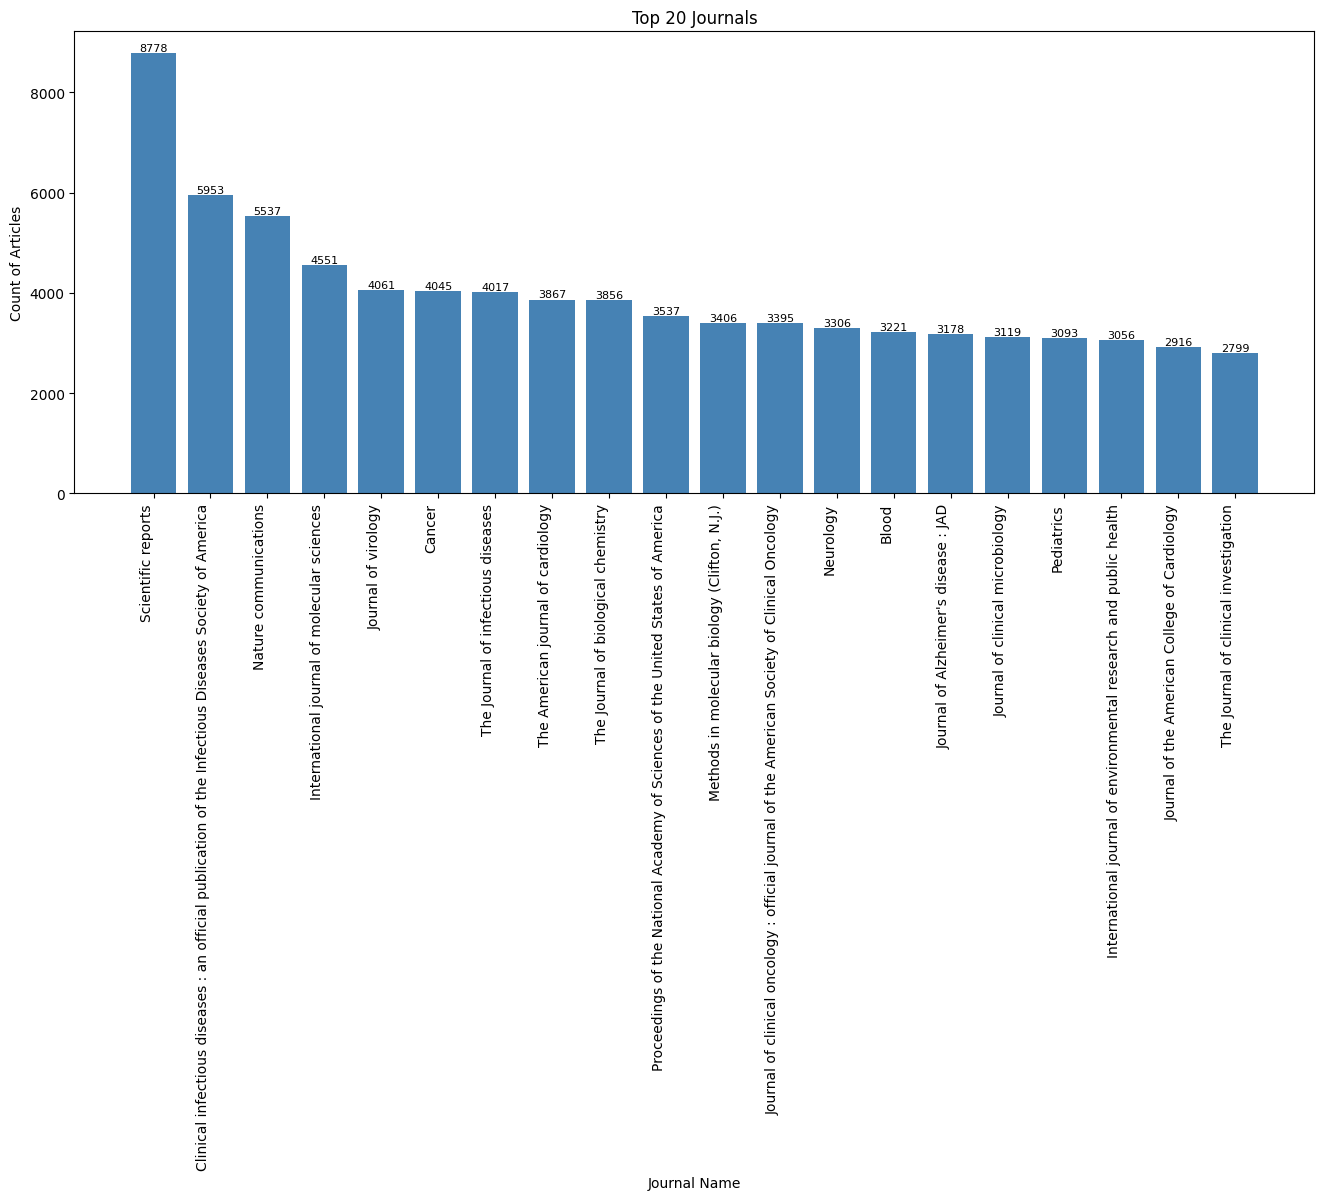

In [19]:
import matplotlib.pyplot as plt

journal_counts = df["journal"].value_counts().head(20)

plt.figure(figsize=(16, 6))
bars = plt.bar(range(len(journal_counts)), journal_counts.values, color='steelblue')

# X-ticks
plt.xticks(range(len(journal_counts)), journal_counts.index, rotation=90, ha='right')
plt.title("Top 20 Journals")
plt.xlabel("Journal Name")
plt.ylabel("Count of Articles")

# Label each bar with its count
for i, rect in enumerate(bars):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, height,
             f"{int(height)}", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Variable: `authors`

Even though we added new variable to dataset, we will not save new dataset with that variable, if this variable is used in further parts we will update 

In [21]:
df["authors_list"] = df["authors"].fillna("").str.split(";").apply(
    lambda x: [a.strip() for a in x if a.strip()]
)

In [22]:
import pandas as pd
from collections import Counter

df["authors_list"] = (
    df["authors"]
    .fillna("")
    .str.split(";")
    .apply(lambda x: [a.strip() for a in x if a.strip()])
)

# Now each row has a Python list of authors
author_counter = Counter()

for authors in df["authors_list"]:
    author_counter.update(authors)

# Inspect top 20 authors
for author, freq in author_counter.most_common(20):
    print(author, freq)


Bennett David A 730
Zheng Wei 600
Wang Wei 588
Zetterberg Henrik 573
Trojanowski John Q 561
Dickson Dennis W 558
Zhang Wei 543
Budoff Matthew J 539
Bhatt Deepak L 528
Petersen Ronald C 527
Li Wei 515
Blennow Kaj 511
Morris John C 509
Jack Clifford R 500
Li Yan 498
Ferrucci Luigi 497
Boerwinkle Eric 471
Li Li 470
Wang Jing 461
Hu Frank B 460


### Variable: `affiliations`

In [ ]:
df["affiliations_list"] = df["affiliations"].fillna("").str.split(";").apply(
    lambda x: [aff.strip() for aff in x if aff.strip()]
)

In [ ]:
aff_counter = df["affiliations"].fillna("").value_counts()
print("Top 20 affiliations:")
print(aff_counter)

In [ ]:
aff_freq = df["affiliations"].value_counts(dropna=False)
print("Number of unique affiliations:", len(aff_freq))
print("Top 20 affiliation strings:")
print(aff_freq.head(20))

### Variable: `mesh_terms`

In [4]:
# df["mesh_list"] = df["mesh_terms"].fillna("").str.split(";").apply(
#     lambda x: [m.strip() for m in x if m.strip()]
# )
df["mesh_list"] = (
    df["mesh_terms"]
    .fillna("")  # replace NaN with empty string
    .str.split(";")
    .apply(lambda x: [m.strip() for m in x if m.strip()])  # strip spaces, remove empties
)

In [5]:
from collections import Counter

mesh_counter = Counter()
for mesh_terms in df["mesh_list"]:
    # mesh_terms is a list, e.g. ["Adolescent", "Adult", ...]
    mesh_counter.update(mesh_terms)

# Turn counter into a DataFrame sorted by frequency
mesh_freq_df = pd.DataFrame(mesh_counter.most_common(), columns=["mesh_term", "count"])
mesh_freq_df.head(20)

,mesh_term,count
0,Humans,1057871
1,Female,472540
2,Male,432617
3,Middle Aged,289180
4,Adult,283915
5,Aged,227184
6,Animals,181045
7,Adolescent,114072
8,Risk Factors,102561
9,Child,96124


In [6]:
# Explode the list so each row in df_exploded is one MeSH term
df_exploded = df.explode("mesh_list")
# Then we can do a value_counts on the single item
mesh_freq = df_exploded["mesh_list"].value_counts(dropna=False)
print("Number of unique MeSH terms:", len(mesh_freq))
print("Top 20 MeSH terms:")
print(mesh_freq.head(20))


Number of unique MeSH terms: 27087
Top 20 MeSH terms:
mesh_list
Humans                       1057871
Female                        472540
Male                          432617
Middle Aged                   289180
Adult                         283915
Aged                          227184
Animals                       181045
Adolescent                    114072
Risk Factors                  102561
Child                          96124
Treatment Outcome              95126
Retrospective Studies          93845
Aged, 80 and over              84418
United States                  83743
Mice                           67297
Young Adult                    64885
Severity of Illness Index      53709
Child, Preschool               52504
Prospective Studies            46072
Follow-Up Studies              45577
Name: count, dtype: int64


In [7]:
# import pandas as pd
# from collections import Counter
# import time

# def author_mesh_combos_in_chunks(df, chunk_size=100_000):
#     """
#     For each chunk of df, explode 'authors_list' and 'mesh_list'
#     and compute counts of (author, mesh) combos, then combine.
#     """
#     combo_counter = Counter()
#     num_rows = len(df)

#     total_start = time.time()

#     for start in range(0, num_rows, chunk_size):
#         end = min(start + chunk_size, num_rows)
#         chunk = df.iloc[start:end].copy()
        
#         # Explode authors_list, then mesh_list
#         chunk = chunk.explode("authors_list")
#         chunk = chunk.explode("mesh_list")
        
#         # Update counter
#         for author, mesh in zip(chunk["authors_list"], chunk["mesh_list"]):
#             if pd.isna(author) or pd.isna(mesh):
#                 continue
#             combo_counter[(author, mesh)] += 1

#         print(f"Processed rows {start} to {end} → combos so far: {len(combo_counter)}. "
#               f"Elapsed: {time.time() - total_start:.2f}s")

#     return combo_counter

# # Usage:
# combos = author_mesh_combos_in_chunks(df, chunk_size=100000)
# # Then convert combos to a DataFrame if desired:
# combos_df = pd.DataFrame([(*k, v) for k, v in combos.items()], columns=["author","mesh","count"])
# combos_df.sort_values("count", ascending=False).head(20)

In [ ]:
df_mesh_list = df[['uid', 'mesh_list']].copy()

In [12]:
import os 

# Folder and file paths
folder_path = "Data/2.Processed/ModellingData"

file_name_mesh_list = "P2_mesh_list.parquet"

file_path_mesh_list = os.path.join(folder_path, file_name_mesh_list)

# 1. Save the DataFrame as a single Parquet file
df_mesh_list.to_parquet(file_path_mesh_list, index=False, compression="snappy")
print(f"DataFrame saved as a single Parquet file: {file_path_mesh_list}")

DataFrame saved as a single Parquet file: Data/2.Processed/ModellingData\P2_mesh_list.parquet


In [ ]:
###############################################################################
# COMPLETE CODE: CHUNK-BASED DISEASE EXTRACTION (BC5CDR) + TIME LEFT ESTIMATE
###############################################################################

import os
import time
import scispacy
import spacy
import pandas as pd
from tqdm.auto import tqdm

###############################################################################
# 1) LOAD BC5CDR MODEL, DISABLING COMPONENTS FOR SPEED
###############################################################################
try:
    nlp_bc5cdr = spacy.load(
        "en_ner_bc5cdr_md", 
        disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
    )
except Exception as e:
    print("Could not load 'en_ner_bc5cdr_md'. Make sure you installed:")
    print("  pip install scispacy")
    print("  pip install en_ner_bc5cdr_md-0.5.4.tar.gz (or your local path)")
    raise e

def extract_diseases_spacy(doc):
    """
    Extract disease mentions from BC5CDR model. (ent.label_ in {CHEMICAL, DISEASE})
    We only keep label == 'DISEASE'.
    """
    diseases = []
    for ent in doc.ents:
        if ent.label_ == "DISEASE":
            diseases.append(ent.text)
    return diseases

###############################################################################
# 2) CHUNK PROCESSING WITH RESUME & TIME REMAIN ESTIMATE
###############################################################################
def process_diseases_in_chunks_with_resume(
    df,
    text_col="title",
    chunk_size=10_000,
    batch_size=32,
    save_path="partial_bc5cdr.parquet"
):
    """
    - df: main DataFrame
    - text_col: column with text to process
    - chunk_size: # of rows per chunk
    - batch_size: # docs per nlp.pipe() batch
    - save_path: Parquet file to store partial/final results

    1) Resumes from an existing partial file if it exists.
    2) Processes row by row in chunks, each chunk using spaCy's pipe for faster NER.
    3) Shows a progress bar + estimates time left based on chunk durations.
    4) Saves partial results after each chunk, then a final full save.
    5) The disease mentions get stored in df["disease_entities_spacy"].
    """
    # Reset index so row order is stable
    df = df.reset_index(drop=True)

    # Initialize the column if absent
    if "disease_entities_spacy" not in df.columns:
        df["disease_entities_spacy"] = None

    # Figure out how many rows are already done if partial file is found
    start_idx = 0
    if os.path.exists(save_path):
        try:
            partial_df = pd.read_parquet(save_path)
            if "disease_entities_spacy" in partial_df.columns:
                df["disease_entities_spacy"] = partial_df["disease_entities_spacy"]
                done_mask = df["disease_entities_spacy"].notna()
                done_rows = done_mask.sum()
                start_idx = done_rows
                print(f"Resuming from row {start_idx} based on partial file {save_path}.")
            else:
                print(f"WARNING: {save_path} lacks 'disease_entities_spacy'. Starting fresh.")
        except Exception as e:
            print(f"Error reading partial file {save_path}: {e}")
            print("Starting from scratch.")
    else:
        print("No partial file found. Starting from scratch.")

    total_rows = len(df)
    if start_idx >= total_rows:
        print(f"All {total_rows} rows processed. Nothing to do.")
        return df

    # Calculate how many chunks remain
    remaining = total_rows - start_idx
    num_chunks = (remaining + chunk_size - 1) // chunk_size
    print(f"Starting chunked processing from row {start_idx}/{total_rows}, "
          f"{remaining} rows left, {num_chunks} chunks.\n")

    cur_row = start_idx
    chunk_times = []  # keep track of each chunk's duration to estimate time left

    # Initialize the progress bar
    with tqdm(total=num_chunks, desc="Processing Chunks", unit="chunk") as pbar:
        for i in range(num_chunks):
            chunk_start_time = time.time()

            end_idx = min(cur_row + chunk_size, total_rows)
            chunk = df.iloc[cur_row:end_idx].copy()
            texts = chunk[text_col].fillna("").tolist()

            # We'll store the results
            results = []

            # Use spaCy pipe in batch
            for doc in nlp_bc5cdr.pipe(texts, batch_size=batch_size):
                diseases = extract_diseases_spacy(doc)
                results.append(diseases)

            # Store in chunk and main df
            chunk["disease_entities_spacy"] = results
            df.iloc[cur_row:end_idx, df.columns.get_loc("disease_entities_spacy")] = chunk["disease_entities_spacy"]

            # Partial save
            df.iloc[:end_idx].to_parquet(save_path, index=False)

            # Chunk timing
            chunk_duration = time.time() - chunk_start_time
            chunk_times.append(chunk_duration)
            chunks_done = i + 1
            chunks_left = num_chunks - chunks_done
            # average chunk time so far
            avg_chunk_time = sum(chunk_times) / chunks_done
            est_time_left = avg_chunk_time * chunks_left

            # Update progress bar description with estimated time left
            pbar.set_postfix({
                "Last Chunk Time": f"{chunk_duration:.1f}s",
                "Est. Time Left": f"{est_time_left/60:.1f} min"
            })
            pbar.update(1)

            cur_row = end_idx

    # Final full save
    df.to_parquet(save_path, index=False)
    print(f"All done! Full results saved to {save_path}.\n")
    return df

###############################################################################
# EXAMPLE USAGE
###############################################################################
if __name__ == "__main__":

    # Convert list of MeSH terms to a single string per row
    df_mesh_list["mesh_list_text"] = df_mesh_list["mesh_list"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

    # Adjust chunk_size, batch_size to fit your environment
    df_mesh_list = process_diseases_in_chunks_with_resume(
        df_mesh_list,
        text_col="mesh_list_text",
        chunk_size=10_000,      
        batch_size=64,      
        save_path="Data/2.Processed/ModellingData/P3.2_bc5cdr_results_mesh_keywords.parquet"
    )

    # Inspect final results
    df_mesh_list[["mesh_list_text", "disease_entities_spacy"]]

In [10]:
df_mesh_list.head()

,uid,mesh_list,mesh_list_text,disease_entities_spacy
0,10186596,"[Financing, Government, HIV Infections, Health...","Financing, Government HIV Infections Health Ca...",[HIV Infections]
1,10186588,"[Female, Health Education, Health Promotion, H...",Female Health Education Health Promotion Human...,[]
2,10186587,"[Delivery of Health Care, Female, Health Care ...",Delivery of Health Care Female Health Care Ref...,[]
3,10163501,"[Adenocarcinoma, Fallopian Tube Neoplasms, Fem...",Adenocarcinoma Fallopian Tube Neoplasms Female...,"[Adenocarcinoma, Neoplasms, Ovarian Neoplasms]"
4,10157383,"[Adolescent, Adult, Black or African American,...",Adolescent Adult Black or African American Asi...,[American Kidney Failure]


In [ ]:
# # Example usage
# if __name__ == "__main__":
#     file_path = "Data/2.Processed/ModellingData/P4_final_merged.parquet"
#     batch_size = 100_000  # Define your desired chunk size
    
#     df = read_parquet_in_batches_with_progress(file_path, batch_size)
    
#     print(f"\nFinal DataFrame with {len(df)} rows:")
#     df.head()

Processing Batches:   0%|          | 0/1057871 [00:00<?, ?rows/s]

Processed Chunk 1: 100000 rows
Processed Chunk 2: 100000 rows
Processed Chunk 3: 100000 rows
Processed Chunk 4: 100000 rows
Processed Chunk 5: 100000 rows
Processed Chunk 6: 100000 rows
Processed Chunk 7: 100000 rows
Processed Chunk 8: 100000 rows
Processed Chunk 9: 100000 rows
Processed Chunk 10: 100000 rows
Processed Chunk 11: 57871 rows

Final DataFrame with 1057871 rows:


In [11]:
# Check for empty lists in 'recognized_diseases'
empty_lists_count_mesh = df_mesh_list['disease_entities_spacy'].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()
print(f"Number of empty lists in recognized_diseases: {empty_lists_count_mesh}")

Number of empty lists in recognized_diseases: 299410


### Variable: `keywords`

### Variable: `coi_statement`